In [6]:
import pandas as pd
#import dask as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* "Microsoft.WebBrowser.Protobuf.UMA.Histograms\\"
    * shows up both in continuous and discrete queries; is this a special type of data-structure?
    
* Questions
    * 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True} ----> why are column names of the type col_name:%d
    * example when PartitioningColumn not in inputColumns:
        device_id v/s DeviceID
        others?
    * sometimes filter input column something like: partialRowNum0


* TODO: combine this with join tables data; Probably can't draw a lot of conclusion about partitioning etc. w/o considering the join workload

* NormInput vs HashTagInput
* inputSelected vs inputColumns
* #FilterColumns vs #FilterColumnsPerSQL. FilterColumns separate plot;
    * #FilterColumns total used for input
    * #Mean, max/min/std filter columns per job per input
* PartitioningColumn Questions:
    * PartitionColumns vs FilterColumns; How often are these the same??
    * #PartitioningColumn
    * Sanity Check: for an input, the #PartitioningColumn (std) == 0??
    * when are partitionin columns === nan / 0; how often / why? does this mean rr partitioning, or something else?
    * only one column is DESC, 550 are ASC!
* Whats up w/ the outlier inputs, e.g., one with inputColumns std peaking at 100??

* Operator questions
    * What kind of operators? distribution for each kind.
    * how often are there multiple filters on SAME column;
    * mixed operators; pairwise distributions; e.g., range + = operators are very rare
    * QUESTION: don't see ANY like operator?????
    
* VertexCount; what does this signify? how often does this change across inputs?

In [4]:
# FN = "combined-0J-2021-05-22.ss.csv"
# INP_FIELD = "NormInput"
# DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]

FN = "../raw_views_filters_2021-12-15.ss.csv"
INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"
DEDUP_FIELDS = [INP_FIELD, FILTER_FIELD]
#INP_FIELD = "HashTagInput"

In [7]:
#df = pd.read_csv(FN, sep="|")
#df = pd.read_csv(FN, sep="\t")
df = dd.read_csv(FN, sep="\t")

In [8]:
#df = df.rename(columns={"#Field:JobGUID":"jobid"})
df = df.rename(columns={"JobGUID":"jobid"})

In [11]:
print(df.head(5))

                                  jobid          HashTagInput  OperatorName  \
0  09fa61d6-85eb-4aa1-a27d-edc967eaf330  13794916223196652713  PhyOp_Filter   
1  0a0fdafe-a097-4e11-a8c2-965d4d644542  11235430612017587489  PhyOp_Filter   
2  392309e0-73a5-4662-8563-8f1118b11a1f  15215909868762634803  PhyOp_Filter   
3  1240bd0f-84ac-4062-b767-e5756f6b35a5  11103072536950829290  PhyOp_Filter   
4  134d0141-ce24-4e45-8db2-cc05111ef25e  15602531293285192605  PhyOp_Filter   

   EstCardinality  InputCardinality  NormInputHashCode   RowCount  \
0    3.127290e+08      3.909110e+08         1474707229          0   
1    3.515620e+03      4.394530e+03         -312151747         14   
2    8.218490e+08      2.006470e+09         -632716426  258432604   
3    6.708930e+06      2.047400e+07         -267767278     146539   
4    1.471070e+10      1.838830e+10         -912689402    1167963   

              Selectivity  ExclusiveTime              StageName  VertexCount  \
0  -1.79769313486232E+308     

In [1072]:
# mdf = df.groupby("HashTagNonStrict")["jobid"].count().reset_index().rename(columns={"jobid":"count"}).sort_values(by="count",
#         ascending=False)

# # jobexploratory = {}
# # jobtemplated = {}

# # for idx,row in mdf.iterrows():
# #     assert row["HashTag"] in df["HashTag"].values
# #     if row["count"] > 5:
# #         jobtemplated[np.uint64(row["HashTag"])] = 1.0
# #         jobexploratory[np.uint64(row["HashTag"])] = 0.0
# #     else:
# #         jobtemplated[np.uint64(row["HashTag"])] = 0.0
# #         jobexploratory[np.uint64(row["HashTag"])] = 1.0

# # #print(jobexploratory)
# # df["exploratory_job"] = df.apply(lambda x: jobexploratory[str(x["HashTag"])] ,axis=1)
# # df["templated_job"] = df.apply(lambda x: jobtemplated[str(x["HashTag"])] ,axis=1)

# THRESH = 10
# df["exploratory_job"] = df.apply(lambda x: int(mdf[mdf.HashTagNonStrict == x["HashTagNonStrict"]]["count"].values[0] <= THRESH) ,axis=1)
# df["templated_job"] = df.apply(lambda x: int(mdf[mdf.HashTagNonStrict == x["HashTagNonStrict"]]["count"].values[0] > THRESH) ,axis=1)
# #df["templated_job"] = df.apply(lambda x: jobtemplated[np.uint64(x["HashTag"])] ,axis=1)   

In [1073]:
# df[["exploratory_job", "templated_job"]].describe()

In [1074]:
# tmpdf = df.drop_duplicates([INP_FIELD, "InputCardinality"])
# print(len(tmpdf))

In [1075]:
# For some analysis, we may not want to drop duplicates here.
#df = df.drop_duplicates(["jobid", INP_FIELD])

# Duplicate and then execute ---> we could group these together, but probably won't make a big difference in the stats we collect

In [14]:
print(len(set(df[INP_FIELD])))

14918


In [15]:
print(len(df))

27319105


In [17]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [19]:
# display(HTML(df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().drop(columns=["InputCardinality", "index"]).\
#     rename(columns={"NormInput":"Number of duplicates \n (Same InputColumns,InputCardinality)"}).\
#     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False).replace("\\n", "<br>")))

In [21]:
# pretty_print(df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().drop(columns=["InputCardinality", "index"]).\
#     rename(columns={"NormInput":"Number of duplicates \\n (Same InputColumns,InputCardinality)"}).\
#     describe(percentiles=[0.9,0.99]).reset_index())

In [22]:
# HTML(df.groupby([INP_FIELD, FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
#                                                                         ascending=False)\
#                                                                         .head(10)\
#                                                                         .to_html(index=False))

In [23]:
# df.groupby([FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
#                                     ascending=False)["jobid"].describe(percentiles=[0.9,0.99])

In [24]:
pretty_print(df.groupby([INP_FIELD, FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
                                    ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
                                    reset_index().\
            rename(columns={"jobid":"Input, FilterExprNorm \\n Duplicates"}))

index,"Input, FilterExprNorm Duplicates"
count,3.089371e+06
mean,8.842934e+00
std,8.795023e+02
min,1.000000e+00
50%,1.000000e+00
90%,4.000000e+00
99%,9.400000e+01
max,1.112862e+06


In [25]:
# pretty_print(df.groupby([INP_FIELD, "InputCardinality", FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
#                                     ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
#                                     reset_index().\
#             rename(columns={"jobid":"Input, InputCardinality, FilterExprNorm \\n Duplicates"}))

In [26]:
# pretty_print(df.groupby(["HashTagInput", "InputCardinality", FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
#                                     ascending=False)["jobid"].describe(percentiles=[0.9,0.99]).\
#                                     reset_index().\
#             rename(columns={"jobid":"Input, InputCardinality, FilterExprNorm \\n Duplicates"}))

In [27]:
# df.groupby([INP_FIELD, "InputCardinality", FILTER_FIELD])["jobid"].count().reset_index().sort_values(by="jobid", 
#                                     ascending=False)["jobid"].describe(percentiles=[0.9,0.99])

In [28]:
# pretty_print(
#     df.groupby([INP_FIELD])["jobid"].nunique().reset_index().rename(columns={"jobid":"unique counts"})\
#         .sort_values(by="unique counts", ascending=False)["unique counts"].describe(percentiles=[0.75,0.9,0.99])\
#         .reset_index()
# )

In [29]:
# pretty_print(
#     df.groupby([INP_FIELD, "InputCardinality"])["jobid"].nunique().reset_index().rename(columns={"jobid":"unique counts"})\
#         .sort_values(by="unique counts", ascending=False)["unique counts"].describe(percentiles=[0.75,0.9,0.99])\
#         .reset_index()
# )

In [30]:
# pretty_print(
#     df.groupby(["HashTagInput"])["jobid"].nunique().reset_index().rename(columns={"jobid":"unique counts"})\
#         .sort_values(by="unique counts", ascending=False)["unique counts"].describe(percentiles=[0.75,0.9,0.99])\
#         .reset_index()
# )

In [31]:
df = df.drop_duplicates(DEDUP_FIELDS)

In [32]:
print(len(set(df[INP_FIELD])))
print(len(df))

14918
3089371


In [33]:
#df[["exploratory_job", "templated_job"]].describe()

In [1347]:
# corr = df.corr().abs()
# corr["VertexCount"].reset_index().sort_values(by="VertexCount", ascending=False)\
#     .rename(columns={"InclusiveTime":"Correlation w/ Runtime"})

In [1348]:
#corr[["InputCardinality", "EstCardinality"]]

In [1349]:
print(len(set(df["inputColumns"])))
print(len(set(df["HashTagInput"])))
print(len(set(df["NormInput"])))
print(len(set(df["NormInputHashCode"])))

1274
2403
1697
1697


In [1350]:
df.groupby("NormInput")["inputColumns"].nunique().reset_index().sort_values(\
    by="inputColumns", ascending=False)

,NormInput,inputColumns
51,adl://asimov-prod-data-cX.azuredatalakestore.n...,7
88,adl://asimov-prod-data-cX.azuredatalakestore.n...,4
1594,adl://protection-prod-cX.azuredatalakestore.ne...,4
1532,adl://protection-prod-cX.azuredatalakestore.ne...,4
1571,adl://protection-prod-cX.azuredatalakestore.ne...,4
...,...,...
577,adl://asimov-prod-data-cX.azuredatalakestore.n...,1
576,adl://asimov-prod-data-cX.azuredatalakestore.n...,1
575,adl://asimov-prod-data-cX.azuredatalakestore.n...,1
574,adl://asimov-prod-data-cX.azuredatalakestore.n...,1


In [1351]:
df.groupby("inputColumns")["NormInput"].nunique().reset_index().sort_values(\
    by="NormInput", ascending=False).head(20)

,inputColumns,NormInput
594,LabelSource#HASH#NormalizedCommandLineSha256#H...,28
976,SpynetReportGuid#HASH#SpynetReportGuidS#HASH#F...,14
1182,device_id#HASH#os_bootId#HASH#buildNum#HASH#os...,13
885,Result#HASH#Owner#HASH#GroupName#HASH#Name#HAS...,11
371,Duration#HASH#PluginGroup#HASH#CountOfStreams,11
593,Label#HASH#Weight#HASH#Sha256#HASH#SigattrEven...,9
579,Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#E...,9
806,ProductId#HASH#ProductContainerDocument,8
586,Label#HASH#Sha256#HASH#Source#HASH#Weight#HASH...,7
970,SpynetReportGuid#HASH#FileQueryIndex#HASH#Spyn...,7


In [1352]:
df.groupby("inputColumns")["NormInput"].nunique().reset_index().sort_values(\
    by="NormInput", ascending=False).head(20)

,inputColumns,NormInput
594,LabelSource#HASH#NormalizedCommandLineSha256#H...,28
976,SpynetReportGuid#HASH#SpynetReportGuidS#HASH#F...,14
1182,device_id#HASH#os_bootId#HASH#buildNum#HASH#os...,13
885,Result#HASH#Owner#HASH#GroupName#HASH#Name#HAS...,11
371,Duration#HASH#PluginGroup#HASH#CountOfStreams,11
593,Label#HASH#Weight#HASH#Sha256#HASH#SigattrEven...,9
579,Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#E...,9
806,ProductId#HASH#ProductContainerDocument,8
586,Label#HASH#Sha256#HASH#Source#HASH#Weight#HASH...,7
970,SpynetReportGuid#HASH#FileQueryIndex#HASH#Spyn...,7


In [1353]:
df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index().sort_values(\
    by="NormInput", ascending=False).head(20)

,inputColumns,InputCardinality,NormInput
4944,FormattedName#HASH#FamilyName#HASH#IsSynthetic...,3.417200e+02,6
9276,VPath#HASH#RateUnhealthy_8#HASH#Sha256#HASH#Ra...,1.378920e+04,4
1622,Comment#HASH#Accuracy#HASH#NegativePrecision#H...,8.961890e+04,3
7825,Sha256#HASH#Label,3.919660e+04,2
9244,UserId#HASH#PurchaseRestriction#HASH#LastModif...,1.301510e+08,2
8715,UniqueUsers#HASH#ClientDeviceType#HASH#DateId#...,8.353000e+01,2
9247,UserId#HASH#PurchaseRestriction#HASH#LastModif...,1.301740e+08,2
4792,FirstUpdatedDate#HASH#OSName#HASH#InstallLangu...,3.089590e+11,2
6829,ProgramVersion#HASH#PackageFullName#HASH#AppNa...,7.469670e+10,2
9248,UserId#HASH#PurchaseRestriction#HASH#LastModif...,1.301840e+08,2


In [1354]:
# df.groupby(["inputColumns","InputCardinality"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).reset_index().describe(percentiles=[0.9,0.99])
# dftmp2 = dftmp[dftmp["NormInput"] > 1]
# print(len(dftmp), len(df))
#dftmp["NormInput"].describe(percentiles=[0.9,0.99])

In [1355]:
df.groupby("inputColumns")["NormInput"].nunique().reset_index().sort_values(\
    by="NormInput", ascending=False).values[0]

array(['LabelSource#HASH#NormalizedCommandLineSha256#HASH#Count#HASH#FileSha256s#HASH#NormalizedCommandLine#HASH#TrainUws#HASH#TrainMalware#HASH#TrainPua#HASH#TrainClean#HASH#LabelUpdateTime#HASH#LabelledBy',
       28], dtype=object)

In [1356]:
#dftmp = df[df.inputColumns == "LabelSource#HASH#NormalizedCommandLineSha256#HASH#Count#HASH#FileSha256s#HASH#NormalizedCommandLine#HASH#TrainUws#HASH#TrainMalware#HASH#TrainPua#HASH#TrainClean#HASH#LabelUpdateTime#HASH#LabelledBy"]

In [1357]:
# df.groupby("inputColumns")["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).describe(percentiles=[0.9, 0.99])

In [1358]:
# df.groupby(["InputCardinality","inputColumns"])["NormInput"].nunique().reset_index().sort_values(\
#     by="NormInput", ascending=False).describe(percentiles=[0.9, 0.99])

In [1359]:
# df.groupby("NormInput")["InputCardinality"].std().reset_index().describe()

In [1360]:
# filter0 = df[FILTER_FIELD].values[10]
# filter0

In [1361]:
# expr0 = df[FILTER_FIELD].values[2010]
# d = json.loads(expr0)
# print(d)
# print(extract_values(d, "name"))

# print(extract_values(d, "expOperator"))
# print(extract_values(d, "values"))

In [1362]:
#df.keys()
def qerr(val1, val2):
    val1 = max(1, val1)
    val2 = max(1, val2)
    q = max (float(val1)/val2, float(val2)/val1)
    return q

In [1363]:
df["Selectivity"] = df.apply(lambda x: min(float(x["RowCount"])/x["InputCardinality"], 1.0) ,axis=1)

In [1364]:
df["QError"] = df.apply(lambda x:  qerr(x["RowCount"], x["EstCardinality"]),axis=1)

In [1365]:
HTML(df["Selectivity"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

index,Selectivity
count,19037.000000
mean,0.271157
std,0.404992
min,0.000000
50%,0.022306
75%,0.408502
90%,1.000000
99%,1.000000
max,1.000000


In [1366]:
HTML(df["QError"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

index,QError
count,1.903700e+04
mean,6.749229e+08
std,1.553292e+10
min,1.000000e+00
50%,3.217441e+01
75%,6.878996e+02
90%,1.466968e+06
99%,6.444780e+09
max,6.552980e+11


In [1367]:
HTML(df["RowCount"].describe(percentiles=[0.75, 0.9, 0.99]).reset_index().to_html(index=False))

index,RowCount
count,1.903700e+04
mean,2.854023e+09
std,3.589523e+10
min,0.000000e+00
50%,1.052647e+06
75%,6.598123e+07
90%,1.114953e+09
99%,2.115454e+10
max,7.560491e+11


In [1368]:
df.groupby(["exploratory_job"])["ExclusiveTime"].describe()

KeyError: 'exploratory_job'

# Amount of time spent in filters vs whole jobs

In [1369]:
HTML(df[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,ExclusiveTime,InclusiveTime
count,1.903700e+04,1.903700e+04
mean,2.959875e+03,1.802702e+04
std,3.257987e+04,1.320208e+05
min,0.000000e+00,1.500000e-02
50%,1.157000e+00,8.668800e+01
90%,1.614610e+03,2.305814e+04
99%,3.264138e+04,3.507295e+05
max,1.527793e+06,1.300253e+07


In [1370]:
#df = df[df.InclusiveTime >= 2.506925e+02]

In [1371]:
def is_num(val):
    try:
        float(val)
        return True
    except:
        return False

def get_discrete_type(vals):
    if len(vals) == 0:
        return ""
    
    val = str(vals[0])
    val = val.replace("@", "")
    val = val.replace("\"", "")
    val = val.replace("\'", "")
    
    if val.lower() == "null" or val.lower() == "none" \
        or val.lower() == "na" or "empty" in val.lower() \
        or val == "":
        return "null"
    
    elif is_num(val):
        #print(val)
        num = float(val)
        if num > 2000 and num <= 2021:
            return "date"
        return "num"
    
    elif "date" in val:
        return "date"
    
#     elif "empty" in val.lower() or val == "":
#         return "empty"
    
#     elif "System" in val:
#         return "system"
#    elif "System"
    elif val.lower() == "true" or val.lower() == "false":
        return "bool"
    
    else:
        #print(val)
        return "string"

In [1372]:
import re

def is_int(num):
    try:
        int(num)
        return True
    except:
        return False

import dateutil.parser as dp
def get_cont_dtype(val):
    if val.lower()[-1] == "d" or val.lower()[-1] == "f":
        val = val[0:-1]
        
    if "date" in val.lower():
        #print(val)
        #valdate = int(val[val.find("(")+1:val.lower().find("l")])
        t = val[val.find("/*")+2:val.find("*/")]
        #print(t)
        #t = '1984-06-02T19:05:00.000Z'
        parsed_t = dp.parse(t)
        t_in_seconds = parsed_t.timestamp()
        #print(t_in_seconds)
        return "date", t_in_seconds
    
    elif is_int(val):
        val = int(val)
        return "int", val
    elif is_num(val):
        val = float(val)
        return "float", val
    elif "proto" in val.lower():
        return "protobuf", None
    else:
        if "-" in val:
            allvals = val.split("-")
            if len(allvals) == 3:
                return "date2", None
            else:
                return "str", None
        else:
            return "str", None
'''
< : 1/0
> : 1/0 
(can be both);
< term: None or L number
> term: 
difference: None OR < minus > term

What if multiple non contiguous ranges?? ---> 1/0 
What if multiple columns with different ranges? ---> 1/0

float vs long vs int vs date vs str;

How will we tell whether moving window style filters OR sth else?
'''
def parse_cont_vals(ops, vals, col_names):
    
    # values to return: one for each column
    ## type: range, lt, gt
    ## dtype:
    ## range: None, or actual value
    ret = {}
    
    cont_idxs = []
    
    cur_comb_op = ""
    for oi, op in enumerate(ops):
        if op == "And" or op == "Or":
            cur_comb_op = op
        
        if ">" in op or "<" in op:
            cont_idxs.append(oi)
            col = col_names[oi]
            
            col = col_names[oi]
            val = vals[oi]
            if isinstance(val, list):
                if len(val) == 0:
                    continue
                assert len(val) == 1
                val = val[0]
            
            val = val.replace("@", "")
            val = val.replace("\"", "")
            val = val.replace("\'", "")
            dtype, pval = get_cont_dtype(val)
            
            if col not in ret:
                ret[col] = {}
            ret[col]["dtype"] = dtype
            if pval is not None and ">" in op:
                ret[col]["gt"] = pval
            elif pval is not None and "<" in op:
                ret[col]["lt"] = pval
            
            ret[col]["comb_op"] = cur_comb_op
    
    for col in ret:
        if "comb_op" in ret[col] and ret[col]["comb_op"] == "Or":
            ctype = "discont"
        
        elif "lt" in ret[col] and "gt" in ret[col]:
            ctype = "range"
            #assert ret[col]["comb_op"] == "And"
            if "comb_op" not in ret[col]:
                print(vals)
                print(ops)

            elif ret[col]["comb_op"] != "And":
                print(vals)
                print(ops)
            
        elif "lt" in ret[col]:
            ctype = "lt"
        elif "gt" in ret[col]:
            ctype = "gt"
        else:
            ctype = "other"
        
        if "lt" in ret[col] and "gt" in ret[col]:
            crange = ret[col]["lt"] - ret[col]["gt"]
            
            #if ret[col]["dtype"] == "date":
                #days = crange / 86400.0
                #ret[col]["range_days"] = days
#             if crange < 0:
#                 print(ret[col]["lt"], ret[col]["gt"])
#                 print(crange)
#                 print(vals)
#                 print(ops)
#                 print(ret[col]["comb_op"])
#                 print("**************")
                #assert crange >= 0.0
            if crange < 0:
                assert ret[col]["comb_op"] == "Or"
            else:
                ret[col]["range"] = crange
        
        ret[col]["cont_type"] = ctype

    return ret


# binaryname.tolower().contains(".cat")
# binaryname.tolower().contains(".hbaked")
# binaryname.tolower().contains(".htm")
# binaryname.tolower().contains(".html")
# binaryname.tolower().contains(".js")
# binaryname.tolower().contains(".man")
# binaryname.tolower().contains(".manifest")
# binaryname.tolower().contains(".mui")
# binaryname.tolower().contains(".mum")
# binaryname.tolower().contains(".png")
# binaryname.tolower().contains(".txt")
# binaryname.tolower().contains(".xml")
# binaryname.tolower().contains(".xrm-ms")


import enchant
enchantD = enchant.Dict("en_US")
import re
#import nltk
#nltk.download('words')
#from nltk.corpus import words as nltkwords

URLPAT = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
def get_like_kind(curop):
    '''
    kinds: prefix,suffix,infix;
    dtypes: path, words, word list / x_y, almost-words (?), serial-ids, num
    like_casting: toupper etc. if it has "to" and "( )";
    
    TODO: almost words dtype
    '''
    likekind = "unknown"
    likecast = 0
    likedtype = "unknown"
    
    if "upper" in curop or "lower" in curop or "invariant" in curop:
        likecast = 1
    
    if "contains" in curop:
        curop = curop[curop.find("contains"):]
        opval = curop[curop.rfind("(")+1:-2]
        likekind = "contains"
    
    elif "like" in curop:
        curop = curop[curop.find("like"):]
        opval = curop[curop.find("\"")+1:curop.rfind("\"")]
        if curop.count("%") == 0:
            likekind = "no%"
        elif curop.count("%") == 2:
            likekind = "contains"
        elif curop.count("%") == 1:
            if opval[0] == "%":
                likekind = "ends"
            elif opval[-1] == "%":
                likekind = "starts"
            else:
                likekind = "no%"
        elif curop.count("%") > 2:
            likekind = "multi%"
        else:
            assert False

    elif "starts" in curop:
        likekind = "starts"
        curop = curop[curop.find("starts"):]
        opval = curop[curop.find("\"")+1:curop.rfind("\"")]
    elif "ends" in curop:
        likekind = "ends"
        curop = curop[curop.find("ends"):curop.find("h")]
        opval = curop[curop.find("\"")+1:curop.rfind("\"")]
    else:
        assert False
    
    opval = opval.replace("%", "")
    opval = opval.replace('"', '')
    opval = opval.replace("@", "")
    
    if is_num(opval):
        likedtype = "num"
    elif len(opval) <= 2:
        likedtype = "short"
    elif opval[0] == ".":
        likedtype = "extension"
    elif re.match(URLPAT, opval) is not None:
        if ("cosmos" in opval or "adl" in opval) and "/" in opval:
            likedtype = "path"
        else:
            likedtype = "url"
            
    elif opval.count("/") >= 2 or opval.count("\\") >= 2:
        likedtype = "path"
        
    elif enchantD.check(opval):
        likedtype = "word"

    elif opval.count("-") >= 2 or \
            opval.count(":") >= 2:
        likedtype = "serial"
    elif "-" in opval or "_" in opval or " " in opval or "," in opval or ":" in opval:
        if "-" in opval:       
            allvals = opval.split("-")
        elif "_" in opval:
            allvals = opval.split("_")
        elif " " in opval:
            allvals = opval.split(" ")
        elif "," in opval:
            allvals = opval.split(",")
        elif ":" in opval:
            allvals = opval.split(":")
            
        validwords = 0
        for v1 in allvals:
            if v1 == "":
                continue
            if enchantD.check(v1):
                validwords += 1
        if validwords >= 2:
            likedtype = "words"
    elif "0x" in opval:
        likedtype = "hex"
    else:
        validwords = 0
        start = 0
        prevstart = 0
        for oi,_ in enumerate(opval):
            cword = opval[start:oi+1]
            pword = opval[prevstart:oi+1]
            if enchantD.check(cword) and len(cword) >= 3:
                validwords += 1
                prevstart = start
                start = oi+1
            
            # extend previous word
            elif enchantD.check(pword) and len(pword) >= 3:
                start = oi+1
                
        if validwords >= 2:
            likedtype = "words"
        
        
    return likekind, likedtype, likecast, curop, opval

# Operators:

##### discretes: =, !=, String.compare, other String.<....> functions
##### continuous: dates, float, ints;
##### likes;
##### udfs;

In [1403]:
cur_row = None

inp_to_filter_cols = defaultdict(set)
inp_to_pcols = defaultdict(set)
inp_to_all_cols = defaultdict(set)

inp_to_ops = defaultdict(set)
inp_to_num_cols = defaultdict(list)

inp_to_discrete_consts = defaultdict(dict)
inp_to_continuous_consts = defaultdict(dict)
inp_to_op_kind = defaultdict(dict)
inp_to_in_consts = defaultdict(dict)

inp_to_like_consts = defaultdict(dict)

num_ops_all = []
num_filter_cols_all = []
num_cols_all = []
num_cols_sel = []
num_unique_ops_all = []
num_pcols = []

like_ops = []
like_lens = []
like_dtype = []
like_kind = []
like_casting = []
like_const = []

discrete_ops = []
discrete_eqs = []
discrete_noneqs = []
discrete_types = []
discrete_types_all = []
types_all = []

nullchecks = []

cont_ops = []
cont_dates = []
cont_others = []

cont_types = []
cont_dtypes = []
cont_ranges = []
cont_cols = []

complex_ops = []
complex_ops_num = []

udf_ops = []
in_ops = []
equal_dates = []
num_discrete_consts = []

num_err = 0

for idx, row in df.iterrows():
    cur_row = row
    expr = row[FILTER_FIELD]
    inpcols_all = row["inputColumns"]
    inp_sel = row["inputSelected"]
    inp = row[INP_FIELD]
    try:
        d = json.loads(expr)
    except:
        num_err += 1 
        num_ops_all.append(-1)
        #num_unique_cols_all.append(-1)
        num_filter_cols_all.append(-1)
        num_unique_ops_all.append(-1)
        num_cols_all.append(-1)
        num_cols_sel.append(-1)
        num_pcols.append(-1)
        like_ops.append(-1)
        discrete_ops.append(-1)
        discrete_eqs.append(-1)
        discrete_noneqs.append(-1)
        cont_ops.append(-1)
        cont_dates.append(-1)
        cont_others.append(-1)
        udf_ops.append(-1)
        in_ops.append(-1)
        equal_dates.append(-1)
        complex_ops.append(-1)
        complex_ops_num.append(-1)
        #discrete_consts.append(-1)
        discrete_types.append(-1)
        discrete_types_all.append(-1)
        num_discrete_consts.append(-1)
        nullchecks.append(-1)
        types_all.append(-1)
        cont_types.append(-1)
        cont_dtypes.append(-1)
        cont_ranges.append(-1)
        like_lens.append(-1)
        cont_cols.append(-1)
        like_dtype.append(-1)
        like_kind.append(-1)
        like_casting.append(-1)
        like_const.append(-1)
        continue
        
    # parse d FOR cosntant values
    filter_values = extract_values(d, "values")
    ops = extract_values(d, "expOperator")
    children = extract_values(d, "children")
    
    likeop = 0
    likelen = 0
    
    udfop = 0
    inop = 0
    discreteop = 0
    discreteeq = 0
    discretenoneq = 0
    contop = 0
    contdate = 0
    contother = 0
    equaldate = 0
    num_discrete_const = 0
    
    complexpred = 0
    complexpredlen = 0
    unknown = 0
    
    nullcheck = 0
    
    typeall = ""
    discrete_type = ""
    discrete_type_all = ""
    
    cont_type = ""
    cont_dtype = ""
    contrange = 0.0
    num_cont_cols = 0

    likekind = ""
    likedtype = ""
    likecast = 0
    likeconst = ""
    
    for fi, fvs in enumerate(filter_values):
        if ops[fi] == "Or":
            # probably IN
            if "IN" in inp_to_op_kind[inp]:
                inp_to_op_kind[inp]["IN"] += 1
            else:
                inp_to_op_kind[inp]["IN"] = 1
            inop = 1
    
            # TODO: can be a mix of >= and =; handle case.
            
            child_vals = extract_values(children[fi], "values")
            #print(child_vals)
            child_vals = [c[0] for c in child_vals if (len(c) > 0 \
                                    and "System.DateTime" not in c[0])]
            num_discrete_const = len(child_vals)
            child_vals.sort()
            child_vals = str(child_vals)
            if child_vals in inp_to_in_consts[inp]:
                inp_to_in_consts[inp][child_vals] += 1
            else:
                inp_to_in_consts[inp][child_vals] = 1           
            continue
        
        # TODO: And + =,!= combination on same column?
        if ops[fi] == "And":
            continue

        # TODO: complex predicates
        if "&&" in ops[fi] or "##" in ops[fi]:
            # complex predicates that are hard to parse
            # TODO: can add threshold on length of these
            complexpred = 1
            complexpredlen = len(ops[fi])
            #typeall += "complex,"
            continue
        
        if "??" in ops[fi]:
            #print(ops[fi])
            nullcheck = 1
            #typeall += "??,"
            continue
            
        if "hasvalue" in ops[fi].lower():
            #print(ops[fi])
            #print(fvs)
            nullcheck = 1
            #typeall += "hasvalue,"
            continue
            
        if "null" in ops[fi].lower():
            #print(ops[fi])
            #print(fvs)
            nullcheck = 1
            #typeall += "null,"
            continue
        
        if "like" in ops[fi].lower() or "starts" in ops[fi].lower() \
            or "contains" in ops[fi].lower() or "endswith" in ops[fi].lower():
            if "LIKE" in inp_to_op_kind[inp]:
                inp_to_op_kind[inp]["LIKE"] += 1
            else:
                inp_to_op_kind[inp]["LIKE"] = 1
            likeop = 1
            assert len(fvs) == 0
            typeall += "like,"
            curop = ops[fi].lower()
            likekind, likedtype, likecast, curop, likeconst = get_like_kind(curop)
            
#             if "contains" in curop:
#                 curop = curop[curop.find("contains"):]
#                 opval = curop[curop.rfind("(")+1:-2]
#             elif "like" in curop:
#                 curop = curop[curop.find("like"):]
#                 opval = curop[curop.find("\"")+1:curop.rfind("\"")]
#                 #print(opval)
#             elif "starts" in curop:
#                 #print("*******")
#                 #print(curop)
#                 curop = curop[curop.find("starts"):]
#                 opval = curop[curop.find("\"")+1:curop.rfind("\"")]
#             elif "ends" in curop:
#                 curop = curop[curop.find("ends"):curop.find("h")]
#                 opval = curop[curop.find("\"")+1:curop.rfind("\"")]
#             else:
#                 assert False
                
            if opval in inp_to_like_consts[inp]:
                inp_to_like_consts[inp][likeconst] += 1
            else:
                inp_to_like_consts[inp][likeconst] = 1
            
            likelen = len(likeconst)
            continue
            
        if "(" in ops[fi] and ")" in ops[fi]:
            # FIXME: sth better.
            udfop = 1
            #print(ops[fi])
            continue
        
        if ops[fi] == "=" or ops[fi] == "!=":
            datetimeop = False
            discrete_type = get_discrete_type(fvs)
            discrete_type_all += discrete_type + ","
            #typeall += "=" + discrete_type + ","
            typeall += "=discrete,"
            
            for const in fvs:
                if "System.DateTime" in const:
                    datetimeop = True
                    break
            
            if not datetimeop:
                curfilterdict = inp_to_discrete_consts
                discreteop = 1
                if num_discrete_const == 0:
                    num_discrete_const = 1
                    child_vals = str(fvs)
                    if child_vals in inp_to_in_consts[inp]:
                        inp_to_in_consts[inp][child_vals] += 1
                    else:
                        inp_to_in_consts[inp][child_vals] = 1
            else:
                equaldate = 1
                #assert ">" in ops[fi] or "<" in ops[fi]
                curfilterdict = inp_to_continuous_consts
                
            if ops[fi] == "=":
                discreteeq = 1
            elif ops[fi] == "!=":
                discretenoneq = 1
                
        elif ">" in ops[fi] or "<" in ops[fi]:
            contop = 1
            #assert ">" in ops[fi] or "<" in ops[fi]
            curfilterdict = inp_to_continuous_consts
            
            #print(fvs)
            
            if len(fvs) != 0:
                if "System.Date" in fvs[0]:
                    contdate = 1
                else:
                    contother = 1
            else:
                continue
        else:
            print(ops[fi])
            unknown = 1
            continue
        
        for const in fvs:
            if const in curfilterdict[inp]:
                curfilterdict[inp][const] += 1
            else:
                curfilterdict[inp][const] = 1
    
    like_ops.append(likeop)
    like_lens.append(likelen)
    like_dtype.append(likedtype)
    like_kind.append(likekind)
    like_casting.append(likecast)
    like_const.append(likeconst)
    
    discrete_ops.append(discreteop)
    discrete_eqs.append(discreteeq)
    discrete_noneqs.append(discretenoneq)
    nullchecks.append(nullcheck)
    
    cont_ops.append(contop)
    cont_dates.append(contdate)
    cont_others.append(contother)
    
    udf_ops.append(udfop)
    in_ops.append(inop)
    equal_dates.append(equaldate)
    num_discrete_consts.append(num_discrete_const)
    discrete_types.append(discrete_type)
    discrete_types_all.append(discrete_type_all)
    
    complex_ops.append(complexpred)
    complex_ops_num.append(complexpredlen)
    
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    
    for fi, fvs in enumerate(filter_values):
        if ">" in ops[fi] or "<" in ops[fi]:
            contdata = parse_cont_vals(ops, filter_values, col_names)
            num_cont_cols = len(contdata)
            for col,curcdata in contdata.items():
                cont_dtype = curcdata["dtype"]
                cont_type = curcdata["cont_type"]
                typeall += cont_type + ","
                if "range" in curcdata:
                    contrange = curcdata["range"]
                    #print(contrange)
            break
    
    types_all.append(typeall)
    cont_types.append(cont_type)
    cont_dtypes.append(cont_dtype)
    cont_ranges.append(contrange)
    cont_cols.append(num_cont_cols)
    
    allcollist = inpcols_all.split("#HASH#")
    for col in allcollist:
        inp_to_all_cols[inp].add(col)
    
    pcols = row["PartitioningColumn"]
    if isinstance(pcols, float):
        curpcols = 0
    else:
        pcols = pcols.split(",")
        curpcols = 0
        for pcol in pcols:
            pcol = pcol.replace(":ASC", "")
            pcol = pcol.replace(":DESC", "")
            inp_to_pcols[inp].add(pcol)
            curpcols += 1
    

    
    #num_cols = len(set(col_names))
    #print(num_cols)
    seen_cols = []
    seen_ops = []
    num_unique_cols = 0
    num_unique_ops = 0
    num_operators = 0
    
    # TODO: loop over col_ops and find the appropriate String.equals etc. kind of commands
    assert len(col_ops) == len(col_names)
    
    for j, col in enumerate(col_names):
        if col == "":
            colop = col_ops[j]      
            if colop.lower() == "and" or colop.lower() == "or":
                continue
            # TODO: if is_like_op(colop): then parse like colname etc.
            # other cases: etc.
            parsedcol = col
        else:
            parsedcol = col[0:col.find(":")]
            
        num_operators += 1
        inp_to_filter_cols[inp].add(parsedcol)
        inp_to_ops[inp].add(col_names[j] + col_ops[j])
        
        if col not in seen_cols:
            num_unique_cols += 1
        if col_ops[j] not in seen_ops:
            num_unique_ops += 1
    
        seen_cols.append(col)
        seen_ops.append(col_ops[j])
    
    #inp_to_num_cols[col].append(inpcols_all.count("#"))
    num_cols_all.append(inpcols_all.count("#") + 1)
    num_cols_sel.append(inp_sel.count("#")+1)
    
    num_ops_all.append(num_operators)
    num_filter_cols_all.append(num_unique_cols)
    num_unique_ops_all.append(num_unique_ops)
    num_pcols.append(curpcols)

print("final num decode errors: ", num_err)

Census_IsVirtualDevice.Value
final num decode errors:  0


In [1404]:
#print(set(cont_ranges))

In [1405]:
num_common_partitions = 0
for inp, cols in inp_to_filter_cols.items():
    for col in cols:
        if col not in inp_to_all_cols[inp]:
            continue

        if col in inp_to_pcols[inp]:
            num_common_partitions += 1
            break
        

In [1406]:
print(num_common_partitions)

237


In [1407]:
print(len(df), len(num_ops_all), len(nullchecks), len(discrete_types))

18885 18885 18885 18885


In [1408]:
df["num_ops"] = num_ops_all
df["num_unique_ops"] = num_unique_ops_all
df["unique_filter_cols"] = num_filter_cols_all 
df["num_cols_all"] = num_cols_all
df["num_cols_sel"] = num_cols_sel
df["num_pcols"] = num_pcols

df["like_ops"] = like_ops
df["like_lens"] = like_lens
df["like_dtype"] = like_dtype
df["like_kind"] = like_kind
df["like_casting"] = like_casting
df["like_const"] = like_const

df["discrete_ops"] = discrete_ops
df["discrete_eqs"] = discrete_eqs
df["discrete_noneqs"] = discrete_noneqs
df["discrete_type"] = discrete_types
df["discrete_types_all"] = discrete_types_all

df["null_checks"] = nullchecks

df["cont_ops"] = cont_ops
df["cont_dates"] = cont_dates
df["cont_others"] = cont_others
df["cont_type"] = cont_types
df["cont_dtype"] = cont_dtypes
df["cont_range"] = cont_ranges
df["cont_cols"] = cont_cols

df["types_all"] = types_all

df["complex_ops"] = complex_ops
df["complex_ops_num"] = complex_ops_num

df["udf_ops"] = udf_ops
df["in_ops"] = in_ops
df["equal_dates"] = equal_dates
df["num_discrete_consts"] = num_discrete_consts

In [1409]:
#print(len(df[df.num_ops == =1]))
df = df[df["num_ops"] != -1]

In [1410]:
df.to_csv("scope_queries.csv", index=False)

# Like exploration

In [1411]:
dflikes = df[df.like_ops == 1]
dflikes.groupby(["like_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

,like_dtype,count,mean,50%,90%
5,short,204.0,130.522912,5.078,60.0932
6,unknown,107.0,15022.911206,66.118,2330.4248
8,word,107.0,72841.797243,14.798,333656.9518
1,hex,50.0,2552.215640,1553.532,7075.8210
9,words,48.0,14929.749813,0.046,858.7962
7,url,33.0,5473.261030,151.732,1241.4440
4,serial,32.0,152.081906,102.708,309.1726
0,extension,24.0,0.063917,0.062,0.1049
2,num,16.0,22820.290875,195.341,94618.0515
3,path,12.0,36948.079000,6.711,126448.2366


In [1412]:
STATCOLS = ["ExclusiveTime", "like_lens", "RowCount", "Selectivity"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
curdrops.append(tuple(["RowCount","mean"]))
curdrops.append(tuple(["Selectivity","mean"]))

pretty_print(dflikes.groupby(["like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))

In [1413]:
pretty_print(dflikes.groupby(["like_kind"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
                  drop(columns=curdrops).\
     rename(columns={"like_lens":"Filter Length"}).\
     round(2))
#      drop(columns=curdrops).\
#      rename(columns={"like_lens":"Filter Length"}).\        
#      round(2))

In [1384]:
pretty_print(dflikes.groupby(["like_kind", "like_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={}).\
     drop(columns=curdrops).round(2))

In [1385]:
dflikes.groupby("like_const")["jobid"].count().reset_index()["jobid"].describe(percentiles=[0.9,0.99])

count    145.000000
mean       4.365517
std       17.123252
min        1.000000
50%        1.000000
90%        4.600000
99%       37.320000
max      195.000000
Name: jobid, dtype: float64

# Summary runtime exploration

In [1304]:
STATSTODROP = ["std", "min", "max", "99%"]

In [1305]:
# HTML(df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
df.groupby(["cont_ops", "discrete_ops","like_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).drop(columns=STATSTODROP)

,cont_ops,discrete_ops,like_ops,count,mean,50%,90%
4,1,0,0,9534.0,1116.761288,2.810,417.6714
6,1,1,0,6049.0,1680.531662,0.661,2302.8088
2,0,1,0,1744.0,2943.064233,6.869,1824.1487
0,0,0,0,925.0,19749.149320,6.045,17706.3722
7,1,1,1,317.0,23313.953189,3.812,2799.0984
1,0,0,1,174.0,13526.642753,438.755,8433.4051
3,0,1,1,87.0,17165.218690,0.402,148.9534
5,1,0,1,55.0,524.429018,66.452,563.6874


In [1306]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

KeyError: "Columns not found: 'templated_job', 'exploratory_job'"

In [ ]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["complex_ops","null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [ ]:
STATCOLS = ["unique_filter_cols", "num_cols_all", "num_cols_sel", "num_pcols"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["cont_ops", "discrete_ops","like_ops"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
                    "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
                    "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
            )

In [ ]:
STATCOLS = ["unique_filter_cols", "num_cols_all", "num_cols_sel", "num_pcols"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

#curdrops.append(tuple(["QError","mean"]))
#curdrops.append(tuple(["VertexCount","mean"]))
#print(curdrops)
pretty_print(df.groupby(["complex_ops", "null_checks"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=(STATCOLS[0],"count"), ascending=False).\
     drop(columns=curdrops).\
     rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE",
                    "unique_filter_cols":"Num Filter Columns", "num_cols_all":"Total Columns",
                    "num_cols_sel":"Num Selected Columns", "num_pcols":"Num Partitioning Columns"}).round(2)
            )

In [1307]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#                  "complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1308]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["InclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1309]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1310]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["QError"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1311]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "null_checks", 
#               "complex_ops"])["VertexCount"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1312]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["unique_filter_cols"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,1,0,9534.0,1.123872,0.331358,1.0,1.0,2.0,2.00,3.0
0,1,1,6049.0,2.646718,1.093817,1.0,2.0,5.0,5.00,10.0
0,0,1,1744.0,1.659404,1.403971,1.0,1.0,3.0,7.00,18.0
0,0,0,925.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
1,1,1,317.0,3.858044,0.981816,3.0,3.0,5.0,5.00,8.0
1,0,0,174.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
1,0,1,87.0,2.390805,0.853942,2.0,2.0,4.0,5.28,7.0
1,1,0,55.0,2.000000,0.000000,2.0,2.0,2.0,2.00,2.0


In [1258]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops", "in_ops", "null_checks", 
#                  "complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1259]:
df.keys()

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'QError', 'num_ops', 'num_unique_ops',
       'unique_filter_cols', 'num_cols_all', 'num_cols_sel', 'num_pcols',
       'like_ops', 'like_lens', 'like_dtype', 'like_kind', 'like_casting',
       'like_const', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'discrete_type', 'discrete_types_all', 'null_checks', 'cont_ops',
       'cont_dates', 'cont_others', 'cont_type', 'cont_dtype', 'cont_range',
       'cont_cols', 'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops',
       'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')

In [1260]:
HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["num_discrete_consts"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,1,0,9534.0,0.000210,0.020483,0.0,0.0,0.0,0.0,2.0
0,1,1,6049.0,1.103984,0.693364,0.0,1.0,2.0,2.0,2.0
0,0,1,1744.0,1.830849,3.242990,1.0,1.0,2.0,18.0,50.0
0,0,0,925.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,1,317.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,0,0,174.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0,1,87.0,0.793103,0.684342,0.0,1.0,1.0,3.0,3.0
1,1,0,55.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# Continuous explorations

In [1261]:
dfcont = df[df.cont_ops == 1]

In [1262]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [1263]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfcont.groupby(["cont_dtype"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_dtype":"Continuous Data \\n Type"}).\
     drop(columns=curdrops).round(2))

In [1264]:
# HTML(dfcont.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1265]:
# HTML(df.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1266]:
# HTML(dfcont.groupby(["cont_dtype"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1267]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1268]:
# HTML(dfcont.groupby(["cont_dtype", "cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1269]:
# HTML(dfcont.groupby(["cont_dtype"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1270]:
# # HTML(df.groupby(["cont_range"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
# #      reset_index().sort_values(by="count", ascending=False).to_html(index=False))
# #print(set(df["cont_range"]))

# HTML(dfcont.groupby(["cont_dtype"])["cont_range"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1271]:
HTML(dfcont.groupby(["cont_cols"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

cont_cols,count,mean,std,min,50%,90%,99%,max
1,15022.0,1854.570846,14820.146312,0.0,1.0800,1329.3891,28271.20761,337741.025
2,903.0,412.416332,2177.656049,0.0,0.1110,1358.2006,3126.73856,28835.235
0,8.0,40.458125,71.434363,0.0,0.4220,129.9704,187.51334,193.907
4,8.0,0.043125,0.054826,0.0,0.0155,0.1081,0.13771,0.141
5,8.0,0.069875,0.035555,0.0,0.0775,0.1021,0.11911,0.121
3,6.0,0.857500,1.371987,0.0,0.3805,2.0525,3.47855,3.637


# Surprising: among range date queries, not so many queries of 1-day to 1-week as you'd expect?

In [1272]:
dfr = df[df.cont_range != 0.0]
dfr = dfr[df.cont_dtype == "date"]
dfr["cont_range_days"] = dfr.apply(lambda x: x["cont_range"] / 86400 ,axis=1)

HTML(dfr.groupby(["cont_dtype"])["cont_range_days"].describe(percentiles=[0.25, 0.40,
                            0.6, 0.75, 0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

<ipython-input-1272-1e49bcd0ab51>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfr = dfr[df.cont_dtype == "date"]


cont_dtype,count,mean,std,min,25%,40%,50%,60%,75%,90%,99%,max
date,4306.0,471.806508,771.06606,0.041667,4.0,8.0,30.0,30.0,555.75,1949.958333,1963.958333,2278.958333


# multi-column explorations

In [1273]:
# HTML(df.groupby(["discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).to_html(index=False))

In [1274]:
HTML(df.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

types_all,count,mean,std,min,50%,90%,99%,max
"gt,",6399.0,5.843067e-01,4.537351e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
"=string,range,",1866.0,2.016701e-02,9.263200e-02,0.000000e+00,1.809943e-03,2.712223e-02,4.433908e-01,1.000000e+00
"range,",1652.0,2.687140e-02,9.699753e-02,0.000000e+00,2.668208e-07,4.664172e-02,7.319963e-01,1.000000e+00
"=num,discont,",1148.0,1.002247e-03,4.991194e-03,0.000000e+00,0.000000e+00,0.000000e+00,3.032681e-02,3.060224e-02
"lt,",942.0,3.867831e-01,3.498855e-01,0.000000e+00,2.061465e-01,1.000000e+00,1.000000e+00,1.000000e+00
"=null,=null,=string,=date,complex,=string,discont,",627.0,2.651247e-02,4.153427e-02,1.189543e-04,4.265698e-03,1.008422e-01,1.082185e-01,1.092844e-01
"=date,",520.0,4.068747e-01,3.545884e-01,0.000000e+00,4.400087e-01,1.000000e+00,1.000000e+00,1.000000e+00
"=string,",427.0,8.282860e-02,2.115634e-01,0.000000e+00,2.374240e-04,3.205458e-01,1.000000e+00,1.000000e+00
"=num,=num,lt,",291.0,3.982752e-01,4.808287e-01,0.000000e+00,2.332908e-02,1.000000e+00,1.000000e+00,1.000000e+00
"=num,",266.0,2.951566e-01,3.883117e-01,0.000000e+00,6.060738e-02,1.000000e+00,1.000000e+00,1.000000e+00


In [1415]:
#df2 = df[df["types_all"].count(",") <= 2]
#df2
types_all = set(df["types_all"].values)
new_types_all = set()
for t in types_all:
    #t2 = t.replace("null,", "")
    if "null" in t:
        continue
    if t.count(",") == 2:
        new_types_all.add(t)

df2 = df[df.types_all.isin(new_types_all)]
# HTML(df2.groupby(["types_all"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().sort_values(by="count", ascending=False).round(2).to_html(index=False))

STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))
curdrops.append(tuple(["QError","mean"]))

pretty_print(df2.groupby(["types_all"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"cont_type":"Continuous Operator \\n Type"}).\
     drop(columns=curdrops).round(2))

In [1414]:
HTML(df.groupby(["types_all"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by="count", ascending=False).to_html(index=False))

types_all,count,mean,std,min,50%,90%,99%,max
"gt,",6505.0,549.323313,7280.675538,0.000,1.1060,226.3108,3.338954e+03,166239.405
"=discrete,range,",1978.0,72.900482,412.685629,0.000,0.0630,1.5929,3.089209e+03,3397.039
"range,",1844.0,2606.458104,4730.697889,0.000,2.0875,11990.5171,1.613135e+04,17365.903
"=discrete,",1536.0,1893.658530,18810.991809,0.000,3.2045,503.6135,2.126793e+04,467844.973
"=discrete,discont,",1199.0,15.549731,329.959554,0.000,0.7920,1.3470,1.613854e+01,8025.587
"lt,",968.0,2269.417956,11562.523444,0.000,59.4245,627.1251,6.939255e+04,74120.886
"=discrete,=discrete,=discrete,=discrete,=discrete,discont,",843.0,9189.698516,10560.367541,0.611,2438.0210,26887.4180,3.060910e+04,32994.307
,355.0,50140.910775,187255.600152,0.000,93.6260,154119.3750,1.263815e+06,1527793.325
"=discrete,=discrete,",334.0,1238.877105,5888.092975,0.000,5.1275,1295.8142,2.701944e+04,66183.444
"=discrete,=discrete,lt,",301.0,27.929505,70.683317,0.000,1.8000,55.7000,6.133400e+01,1011.068


# Filter by templated query or not

In [1314]:
import copy
dfall = copy.deepcopy(df)

In [1315]:
print(len(set(df["HashTagNonStrict"])))
dftmp = df.groupby("HashTagNonStrict").count()["jobid"].reset_index()
#print(len(dftmp))
#print(dftmp.head(5))
df = dfall
THRESH = 10
dftmp1 = dftmp[dftmp["jobid"] <= THRESH]
dftmp2 = dftmp[dftmp["jobid"] > THRESH]

repeating_tmps = dftmp2["HashTagNonStrict"].values
not_repeating_tmps = dftmp1["HashTagNonStrict"].values
print(len(repeating_tmps), len(not_repeating_tmps))

import copy

dfrep = df[df["HashTagNonStrict"].isin(repeating_tmps)]
dfnonrep = df[df["HashTagNonStrict"].isin(not_repeating_tmps)]

5278
228 5050


In [1316]:
#df = dfall

In [1317]:
#HTML(dfrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [1318]:
#df.keys()

In [1319]:
#HTML(dfnonrep[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [1320]:
HTML(df[["like_ops", "discrete_ops", "cont_ops", "in_ops"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,like_ops,discrete_ops,cont_ops,in_ops
count,18885.000000,18885.000000,18885.000000,18885.000000
mean,0.033519,0.434048,0.844850,0.188880
std,0.179991,0.495644,0.362057,0.391424
min,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
90%,0.000000,1.000000,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [1321]:
HTML(df[["like_ops", "discrete_ops", "discrete_eqs", "discrete_noneqs", "in_ops",
         "complex_ops",
         "cont_ops", 
         "cont_dates", "cont_others"]].\
     mean().reset_index().to_html(index=False))

index,0
like_ops,0.033519
discrete_ops,0.434048
discrete_eqs,0.390998
discrete_noneqs,0.144771
in_ops,0.188880
complex_ops,0.089383
cont_ops,0.844850
cont_dates,0.773047
cont_others,0.112100


# More discrete exploration

In [1390]:
dfdisc = df[df.discrete_ops == 1]
dfdisc = dfdisc[dfdisc.discrete_type != ""]
print(len(df), len(dfdisc))
#HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
#     .reset_index().to_html(index=True))

HTML(dfdisc.groupby(["discrete_eqs", "discrete_type", "in_ops"]).count()["jobid"].\
     reset_index().to_html(index=False))

18885 8141


discrete_eqs,discrete_type,in_ops,jobid
0,bool,0,30
0,date,0,1
0,date,1,130
0,null,0,448
0,null,1,5
0,num,0,157
0,string,0,298
0,string,1,7
1,bool,0,499
1,bool,1,59


In [1391]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [1174]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["discrete_eqs"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type"}).\
     drop(columns=curdrops).round(2))

In [1175]:
STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount"]
curdrops = []
for si, stc in enumerate(STATCOLS):
    for sdrop in STATSTODROP:
        curdrops.append(tuple([stc, sdrop]))
    if si != 0:
        curdrops.append(tuple([stc,"count"]))

curdrops.append(tuple(["QError","mean"]))
pretty_print(dfdisc.groupby(["like_ops", "discrete_type"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
     reset_index().sort_values(by=("Selectivity","count"), ascending=False).\
     rename(columns={"discrete_type":"Discrete Type", "like_ops":"LIKE"}).\
     drop(columns=curdrops).round(2))

In [1176]:
HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,30.0,0.052995,0.115369,0.000031,0.000052,0.265904,0.354191,0.356966
0,null,453.0,0.220398,0.364249,0.000000,0.015512,1.000000,1.000000,1.000000
0,num,287.0,0.644559,0.445128,0.000000,1.000000,1.000000,1.000000,1.000000
0,string,306.0,0.115172,0.237986,0.000000,0.027194,0.427581,1.000000,1.000000
1,bool,558.0,0.067082,0.183091,0.000000,0.000272,0.193001,1.000000,1.000000
1,null,97.0,0.058148,0.130653,0.000000,0.006689,0.134702,0.499981,1.000000
1,num,2712.0,0.027479,0.124995,0.000000,0.000192,0.023313,0.974196,1.000000
1,string,3698.0,0.029214,0.102807,0.000000,0.001794,0.067018,0.615261,1.000000


### Note: discrete_eq + boolean ----> much higher runtime than any other group;
### Note2: actually, like_ops + bool ----> much higher runtimes

In [1177]:
HTML(dfdisc.groupby(["like_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,discrete_type,count,mean,std,min,50%,90%,99%,max
0,bool,462.0,2481.725149,19332.176140,0.0,2.0305,2352.4846,34421.95167,244648.188
0,null,517.0,2576.910731,14646.377158,0.0,1.2160,3994.0690,29297.90436,288006.623
0,num,2969.0,375.100197,7079.947066,0.0,0.6610,51.0948,6354.85492,366535.327
0,string,3790.0,2963.507844,9472.847174,0.0,0.8760,14025.6042,29870.24001,275790.820
1,bool,126.0,70066.257500,176585.588003,0.0,0.0860,333380.8595,337602.96825,1442419.293
1,null,33.0,31.014061,156.256190,0.0,2.6800,3.1240,626.09232,900.548
1,num,30.0,92.521267,222.384829,0.0,11.5155,126.1624,916.21156,1229.596
1,string,214.0,241.820748,3026.892090,0.0,4.1000,60.2208,332.11127,44306.693


In [1178]:
HTML(dfdisc.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

like_ops,cont_ops,discrete_ops,count,mean,std,min,50%,90%,99%,max
0,0,1,1738.0,2680.727882,15453.384634,0.0,6.7695,1764.6774,30550.24713,366535.327
0,1,1,6000.0,1694.180337,7823.928208,0.0,0.6430,2332.5176,28594.95735,244648.188
1,0,1,87.0,17165.218690,154652.925107,0.0,0.4020,148.9534,240042.45700,1442419.293
1,1,1,316.0,23387.731522,84758.398111,0.0,3.8210,2799.6310,336650.00620,337741.025


In [1179]:
# HTML(df.groupby(["like_ops", "cont_ops", "discrete_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# Like Ops when discrete_ops = 0

In [1180]:
# HTML(dfdisc.groupby(["unique_filter_cols", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

In [1181]:
# HTML(dfdisc.groupby(["num_ops", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
#      reset_index().to_html(index=False))

# ComplexOps ---> More runtime

In [1182]:
HTML(df.groupby(["complex_ops"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

complex_ops,count,mean,std,min,50%,90%,99%,max
0,17197.0,2257.440245,31836.067565,0.0,1.095,411.6848,22484.81276,1527793.325
1,1688.0,9868.828213,38017.681027,0.0,37.397,25965.7642,177687.03908,1101570.609


In [1183]:
HTML(df.groupby(["complex_ops"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

complex_ops,count,mean,std,min,50%,90%,99%,max
0,17197.0,0.297094,0.416705,0.0,0.024383,1.00000,1.000000,1.0
1,1688.0,0.020016,0.055290,0.0,0.004127,0.09416,0.148209,1.0


# Extreme cases

In [1184]:
# dfext = df[df["ExclusiveTime"] == 1546313.691]
# print(dfext.keys())
# print(dfext[FILTER_FIELD].values[0])
# dfext[["OperatorName", "InputCardinality", "VertexCount", "RowCount", "Selectivity", "num_ops", 
#       "num_unique_ops", "unique_filter_cols", "num_cols_all", "num_pcols", "like_ops", 
#       "cont_ops", "cont_dates", "udf_ops"]]

# Top few execution time ones are just String.isNullOrEmpty;
# Next is = true + LIKE predicate

In [1185]:
# dftmp = df.sort_values(by="ExclusiveTime", ascending=False)
# NUM=50
# print(dftmp["ExclusiveTime"].head(NUM))
# for i in range(NUM):
#     print(dftmp[FILTER_FIELD].values[i])

In [1186]:
df["VertexCount"].describe(percentiles=[0.9, 0.99])

count    18885.000000
mean       302.305322
std        693.193948
min          1.000000
50%         13.000000
90%       1000.000000
99%       2500.000000
max      10515.000000
Name: VertexCount, dtype: float64

In [1187]:
# corr = df.corr().abs()
# corr["InclusiveTime"].reset_index().sort_values(by="InclusiveTime", ascending=False)\
#     .rename(columns={"InclusiveTime":"Correlation w/ Runtime"})

# Exploring likes

In [1188]:
df.groupby("like_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,18252.0,2422.386878,28449.493396,0.0,1.092,1460.3796,29673.23331,1527793.325
1,633.0,17798.383289,89297.360405,0.0,55.622,2872.9664,335593.01044,1442419.293


In [1189]:
#df.groupby("discrete_ops")["ExclusiveTime"].describe(percentiles=[0.9, 0.99])

In [1190]:
df.groupby("like_ops")["Selectivity"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,18252.0,0.280623,0.409745,0.0,0.022412,1.000000,1.000000,1.0
1,633.0,0.033137,0.108805,0.0,0.000796,0.041457,0.565701,1.0


In [1191]:
df.groupby("like_ops")["RowCount"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
like_ops,,,,,,,,
0,18252.0,2.950834e+09,3.662202e+10,0.0,1096342.0,1.115423e+09,2.118304e+10,7.560491e+11
1,633.0,1.827469e+08,1.204816e+09,0.0,68180.0,8.551879e+07,2.190538e+09,1.879141e+10


In [1192]:
pretty_print(
    dflikes.groupby("like_ops")[["like_lens"]].describe(percentiles=[0.7, 0.9, 0.99]).\
    reset_index().\
    rename(columns={"like_lens": "Length of like filter", "like_ops":"LIKE"})
)

In [1193]:
dflikes = df[df.like_ops == 1]
dflikes = dflikes.sort_values(by="like_lens")
HTML(dflikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExprNorm,ExclusiveTime,Selectivity
2008,1,"{""isComparison"":true,""expOperator"":""device_id.StartsWith(\""g\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",0.078,1.000000e+00
54961,1,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""ForbiddenValueList.Contains(\"",\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""RequiredValueList.Contains(\"",\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",0.000,6.830031e-05
40985,1,"{""isComparison"":true,""expOperator"":""data.Contains(\""{\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",6.059,2.053507e-02
37228,1,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""TargetOs:1"",""dataType"":""String""},""values"":[""@\""20H1\""""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""SdbEntries_item_SdbEntryGuid.Contains(\""{\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",148.949,5.322101e-05
1254,1,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""FinancialSku.Contains(\"",\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""string.IsNullOrEmpty(FinancialSku)"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",0.251,2.495444e-01
30380,1,"{""isComparison"":true,""expOperator"":""data.Contains(\""{\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",6.010,2.089607e-02
85987,1,"{""isComparison"":true,""expOperator"":""data.Contains(\""{\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",14.540,1.986461e-02
64045,2,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":"""",""dataType"":""Bool""},""values"":[""false""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""IsTestLab:10"",""dataType"":""Bool""},""values"":[""false""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""RetailChannel:104"",""dataType"":""String""},""values"":[""\""Retail\""""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""LastUpdatedDate:47"",""dataType"":""Date""},""values"":[""System.DateTime.FromBinary(5249216938359931839L /* 2021-04-04T00:13:13.2543935Z */)""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":"">="",""attribute"":{""name"":""TelemetryLevel:76"",""dataType"":""Int""},""values"":[""2""],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""DeviceId.StartsWith(\""g:\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",65.310,4.125901e-02
69868,2,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""="",""attribute"":{""name"":""Project:100"",""dataType"":""String""},""values"":[""\""Carina\""""],""children"":[],""isSorted"":true},{""isComparison"":tr

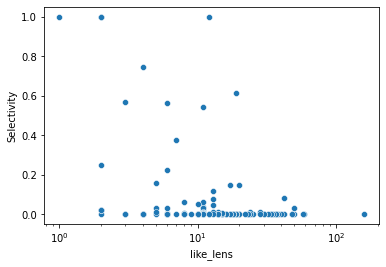

In [1194]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="Selectivity")
plt.xscale("log")
#plt.yscale("log")

(0.0, 1000.0)

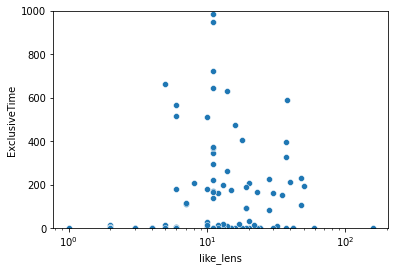

In [1195]:
sns.scatterplot(data=dfonlylikes, x="like_lens", y="ExclusiveTime")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,0.1e4])

In [1196]:
#df.groupby("like_ops")["ExclusiveTime"].sum()

In [1197]:
dfonlylikes = df[df.like_ops == 1]
dfonlylikes = dfonlylikes[dfonlylikes.discrete_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.cont_ops == 0]
dfonlylikes = dfonlylikes[dfonlylikes.complex_ops == 0]
HTML(dfonlylikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [1198]:
dfonlylikes.groupby("like_ops")["like_lens"].describe(percentiles=[0.7, 0.9, 0.99])

,count,mean,std,min,50%,70%,90%,99%,max
like_ops,,,,,,,,,
1,174.0,14.086207,15.207183,1.0,10.0,14.0,31.1,56.54,158.0


In [1199]:
#dfonlylikes = dfonlylikes.sort_values(by="like_lens")
dfonlylikes = dfonlylikes.sort_values(by="like_lens", ascending=False)
HTML(dfonlylikes.head(20)[["like_lens", FILTER_FIELD, "ExclusiveTime", "Selectivity"]].to_html())

,like_lens,FilterExprNorm,ExclusiveTime,Selectivity
142622,158,"{""isComparison"":true,""expOperator"":""InputPath.StartsWith(\""adl://asimov-prod-data-c15.azuredatalakestore.net/local/PublicPartner/Staging/WxaaSFactTables/Prod/WxaaSDeviceFactTable/v2/Daily/2021/05/ConnectivityHeartBeat\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",1.933,0.000000e+00
8687,58,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""Utility.SafeToUpper(EntitlementKeys).Contains(\""BIG:CFQ7TTC0K6L8:0004\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""Utility.SafeToUpper(EntitlementKeys).Contains(\""XBX:SUBSCRIPTION:66BC4555-FA25-428F-BAAC-8C057955D892:FULL\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",0.000,1.729858e-04
18205,56,"{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(JobName, \""%MSaaS.Data.Integration.SkylightContentCoverage.Scope.INT%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",21951.757,8.166273e-08
7048,48,"{""isComparison"":true,""expOperator"":""EventName.Contains(@\""Microsoft.Windows.FileSystem.FltMgr.InitInstance\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",192.959,3.016529e-02
47027,48,"{""isComparison"":false,""expOperator"":""Or"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(StreamPath, \""%/Processed/Default/SelfHelp/SkylightSurvey/SkylightSurvey.ss%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(StreamPath, \""%/Staging/BaseModel/Survey/SurveyQuestionAnswer/SurveyQuestionAnswer.Skylight.ss%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(StreamPath, \""%/Staging/BaseModel/Survey/SurveyResponse/SurveyResponse.Skylight.ss%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(StreamPath, \""%Secured/Incident/Survey/ChatSurvey/ChatSurvey.Ces.ss%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""ScopeEngineManaged.ScopeLikeUtil.Like(StreamPath, \""%Secured/Incident/Survey/ChatSurvey/ChatSurvey.ss%\"", '\\0')"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}],""isSorted"":true}",109715.430,6.509541e-06
27743,40,"{""isComparison"":true,""expOperator"":""EventName.Contains(@\""F3C5E28E-63F6-49C7-A204-E48A1BC4B09D.1_1\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",0.268,1.451028e-03
2592,40,"{""isComparison"":true,""expOperator"":""EventName.Contains(@\""F3C5E28E-63F6-49C7-A204-E48A1BC4B09D.6_1\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true}",0.751,8.073300e-02
23337,38,"{""isComparison"":false,""expOperator"":""And"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[{""isComparison"":true,""expOperator"":""data.Contains(@\""\""\""EventName\""\"":\""\""appcrash\""\""\"")"",""attribute"":{""name"":"""",""dataType"":""""},""values"":[],""children"":[],""isSorted"":true},{""isComparison"":true,""expOperator"":""data.Contains(@\""\""\""SignaturePa

In [1200]:
dflikes = df[df.like_ops == 1]
HTML(dflikes.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [1201]:
dflikedisc = df[df.like_ops == 1]
dflikedisc = dflikedisc[dflikedisc.discrete_ops == 1]
HTML(dflikedisc.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

# Correlations

In [1202]:
print(df.keys())
tmpdf = df[["OperatorName", "EstCardinality", "InputCardinality", "PartitioningColumn",
           'SortColumn', 
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'discrete_eqs', 'discrete_noneqs', 'discrete_type', 'null_checks',
       'cont_ops', 'cont_dates', 'cont_others', 'complex_ops',
       'complex_ops_num', 'udf_ops', 'in_ops', 'equal_dates',
       'num_discrete_consts', 'discrete_types_all', 'cont_type', 'cont_dtype',
       'cont_range', 'types_all', 'like_lens']]
corr = tmpdf.corr()

HTML(corr.round(2).to_html())

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'QError', 'num_ops', 'num_unique_ops',
       'unique_filter_cols', 'num_cols_all', 'num_cols_sel', 'num_pcols',
       'like_ops', 'like_lens', 'like_dtype', 'like_kind', 'like_casting',
       'like_const', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'discrete_type', 'discrete_types_all', 'null_checks', 'cont_ops',
       'cont_dates', 'cont_others', 'cont_type', 'cont_dtype', 'cont_range',
       'cont_cols', 'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops',
       'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')


,EstCardinality,InputCardinality,InclusiveTime,ExclusiveTime,VertexCount,RowCount,Selectivity,num_ops,num_unique_ops,unique_filter_cols,num_cols_all,num_cols_sel,num_pcols,like_ops,discrete_ops,discrete_eqs,discrete_noneqs,null_checks,cont_ops,cont_dates,cont_others,complex_ops,complex_ops_num,udf_ops,in_ops,equal_dates,num_discrete_consts,cont_range,like_lens
EstCardinality,1.00,0.93,0.43,0.16,0.42,0.64,-0.05,-0.02,-0.04,-0.00,0.04,-0.02,0.05,-0.00,-0.03,-0.01,0.01,0.04,-0.06,-0.06,0.01,0.02,0.00,-0.04,-0.03,0.05,-0.00,-0.03,-0.00
InputCardinality,0.93,1.00,0.48,0.19,0.49,0.55,-0.08,0.08,0.03,0.13,0.09,0.01,0.04,0.00,0.02,0.03,0.10,0.08,-0.05,-0.11,0.10,0.12,0.03,-0.05,0.02,0.14,0.03,-0.04,-0.00
InclusiveTime,0.43,0.48,1.00,0.33,0.31,0.27,-0.05,0.04,0.01,0.07,0.08,0.01,0.01,0.02,0.01,0.01,0.05,0.07,-0.06,-0.08,0.05,0.08,0.03,-0.01,0.01,0.05,0.01,-0.03,0.01
ExclusiveTime,0.16,0.19,0.33,1.00,0.14,0.11,-0.04,0.02,0.01,0.04,0.09,0.00,-0.01,0.09,0.00,0.00,0.02,0.08,-0.08,-0.09,0.01,0.07,0.01,-0.00,0.00,0.03,0.01,-0.02,0.03
VertexCount,0.42,0.49,0.31,0.14,1.00,0.21,-0.18,0.12,0.10,0.18,0.46,0.01,0.29,0.02,-0.05,-0.05,0.09,0.18,-0.04,-0.10,0.09,0.16,0.13,0.10,-0.04,0.13,0.01,-0.10,0.03
RowCount,0.64,0.55,0.27,0.11,0.21,1.00,0.08,-0.05,-0.06,-0.04,-0.03,0.00,0.04,-0.01,-0.03,-0.06,0.02,-0.00,-0.02,-0.01,-0.02,-0.02,-0.01,-0.03,-0.03,-0.02,-0.02,-0.02,-0.01
Selectivity,-0.05,-0.08,-0.05,-0.04,-0.18,0.08,1.00,-0.40,-0.47,-0.36,-0.31,-0.12,-0.14,-0.11,-0.43,-0.46,-0.06,-0.10,0.09,0.12,-0.15,-0.19,-0.14,-0.26,-0.22,-0.05,-0.21,-0.15,-0.07
num_ops,-0.02,0.08,0.04,0.02,0.12,-0.05,-0.40,1.00,0.76,0.75,0.21,0.21,-0.03,0.14,0.60,0.55,0.35,0.11,0.05,-0.12,0.32,0.47,0.28,0.27,0.52,0.20,0.66,0.06,0.06
num_unique_ops,-0.04,0.03,0.01,0.01,0.10,-0.06,-0.47,0.76,1.00,0.68,0.24,0.24,-0.04,0.19,0.62,0.57,0.26,0.15,0.23,0.09,0.26,0.32,0.22,0.52,0.43,0.09,0.20,0.16,0.10
unique_filter_cols,-0.00,0.13,0.07,0.04,0.18,-0.04,-0.36,0.75,0.68,1.00,0.28,0.21,-0.02,0.17,0.62,0.54,0.55,0.14,0.11,-0.18,0.53,0.55,0.22,0.10,0.43,0.32,0.33,0.06,0.04


# why is this an extreme outlier?

In [1203]:
dflikebool = df[df.like_ops == 1]
dflikebool = dflikebool[dflikebool.discrete_type == "bool"]
HTML(dflikebool.groupby(["like_ops"])[["ExclusiveTime", "Selectivity"]].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

In [1204]:
#dflikebool[FILTER_FIELD].values[5]

# Continuous exploration

In [1205]:
dfcont = df[df.cont_ops == 1]
print(len(df), len(dfcont))
#HTML(dfdisc.groupby("discrete_type").count()["jobid"].describe(percentiles=[0.9,0.99])\
#     .reset_index().to_html(index=True))

# HTML(dfdisc.groupby(["discrete_eqs", "discrete_type"]).count()["jobid"].\
#      reset_index().to_html(index=False))

18885 15955


### Note: continuous operators seem to typically have higher selectivity than discrete operators
### Note: 90th percentile difference b/w date vs nodate

In [1206]:
HTML(dfcont.groupby(["cont_dates"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,count,mean,std,min,50%,90%,99%,max
0,1356.0,0.154836,0.314114,0.0,0.004330,0.965065,1.0,1.0
1,14599.0,0.299792,0.424502,0.0,0.022486,1.000000,1.0,1.0


In [1207]:
HTML(dfcont.groupby(["cont_dates"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,count,mean,std,min,50%,90%,99%,max
0,1356.0,5995.432625,10228.488224,0.0,1350.192,22911.542,30269.2166,155865.902
1,14599.0,1376.964057,14659.390483,0.0,0.905,243.604,15790.4198,337741.025


In [1208]:
HTML(dfcont.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,8.0,40.458125,71.434363,0.0,0.4220,129.9704,187.51334,193.907
discont,2633.0,2967.345411,7349.004886,0.0,0.9960,16216.5778,29675.25092,32994.307
gt,7494.0,1547.897762,19308.447701,0.0,1.6710,236.5652,5335.04018,337741.025
lt,1410.0,1709.198019,9675.077457,0.0,58.0045,446.8675,67794.31250,74120.886
other,52.0,2.097173,2.180870,0.0,0.1730,4.7171,5.44248,5.826
range,4358.0,1470.568307,7313.215753,0.0,0.4655,4492.2138,16173.88300,244648.188


In [1209]:
dfnodate = dfcont[dfcont.cont_dates == 0]
HTML(dfnodate.groupby(["cont_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,8.0,0.168859,0.343801,0.000000e+00,0.024598,0.450411,0.945041,1.000000
discont,633.0,0.028895,0.049619,1.189543e-04,0.004269,0.100986,0.109276,0.539967
gt,279.0,0.242744,0.369612,0.000000e+00,0.016884,1.000000,1.000000,1.000000
lt,332.0,0.337788,0.434498,0.000000e+00,0.041125,1.000000,1.000000,1.000000
other,52.0,0.002120,0.012973,0.000000e+00,0.000003,0.000014,0.050369,0.093154
range,52.0,0.198750,0.349006,2.852158e-08,0.000597,0.974518,1.000000,1.000000


In [1210]:
HTML(dfnodate.groupby(["cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_type,count,mean,std,min,50%,90%,99%,max
,8.0,40.458125,71.434363,0.000,0.422,129.9704,187.51334,193.907
discont,633.0,12265.802269,10523.386514,1.116,12542.883,27846.6282,30906.61092,32994.307
gt,279.0,979.041459,9450.044592,0.000,0.048,1572.1794,12676.31302,155865.902
lt,332.0,249.799822,639.459423,0.000,51.023,369.7508,2425.83926,2708.400
other,52.0,2.097173,2.180870,0.000,0.173,4.7171,5.44248,5.826
range,52.0,173.749558,760.753848,0.000,25.471,73.7056,3278.94316,5200.003


# cont_dates=0, type = discont ---> huge outlier; seems to be because of discrete ops; not clear why;
# TODO: have some statistic about how many tables contribute to these outliers?

In [1211]:
HTML(dfcont.groupby(["cont_dates","cont_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,cont_type,count,mean,std,min,50%,90%,99%,max
0,,8.0,40.458125,71.434363,0.000,0.4220,129.9704,187.51334,193.907
0,discont,633.0,12265.802269,10523.386514,1.116,12542.8830,27846.6282,30906.61092,32994.307
0,gt,279.0,979.041459,9450.044592,0.000,0.0480,1572.1794,12676.31302,155865.902
0,lt,332.0,249.799822,639.459423,0.000,51.0230,369.7508,2425.83926,2708.400
0,other,52.0,2.097173,2.180870,0.000,0.1730,4.7171,5.44248,5.826
0,range,52.0,173.749558,760.753848,0.000,25.4710,73.7056,3278.94316,5200.003
1,discont,2000.0,24.383816,232.373656,0.000,0.0790,1.3001,1344.05935,5959.417
1,gt,7215.0,1569.895116,19590.312241,0.000,1.7530,235.5546,5281.97260,337741.025
1,lt,1078.0,2158.660173,11021.722764,0.000,58.8705,448.3572,68419.74564,74120.886
1,range,4306.0,1486.228915,7355.387883,0.000,0.4235,4540.2735,16177.62700,244648.188


# 0, discont explained partially by the few unique inputs; TODO: look further into what those discont ops were

In [1212]:
HTML(dfcont.groupby(["cont_dates","cont_type"])[INP_FIELD].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,cont_type,count,unique,top,freq
0,,8,7,adl://cp-bizops-cX.azuredatalakestore.net/local/users/v-yiwzho/Azure/AzureNonPayment/X_X/AzureSubGuidStatus_NonPayment.ss,2
0,discont,633,7,adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/EdgeAnaheim/DataPipeline/Instance/X/X/X/AnaheimEvents.HistogramEvent_vX_X_X_X_X.ss,448
0,gt,279,150,adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/DEP/WinTheDevBox/Terminal/TerminalFunnelStagesInputStreams/X/X/TerminalInteractivity_X_X_X.ss,24
0,lt,332,55,adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/WSD.Upgrade/LongTerm/CleanInstall/CleanInstall.ss,163
0,other,52,6,adl://marketplace-dce-prod-cX.azuredatalakestore.net/local/Public/Staging/Developer/Analytics/CustomEvents/Daily/vX/X/X/CustomEvent_X_X_X.ss,24
0,range,52,29,adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MRW/AppEvents/vX/Dataset/MRW.AppEventsConsolidated.ss,24
1,discont,2000,20,adl://cp-testlx-activityreports-cX.azuredatalakestore.net/local/RatingPeriod/StreamX/RatingGroup/vX/Partitions/RatingGroupMasterStream_X.ss,576
1,gt,7215,154,adl://wlxsafety-bao-cX.azuredatalakestore.net/local/Abuse/BPLs/skype_lw_signup.ss,577
1,lt,1078,31,adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Chat/ChatTranscript.ss,565
1,range,4306,75,adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss,972


In [1213]:
dftmp = df[df[INP_FIELD] == 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/EdgeAnaheim/DataPipeline/Instance/X/X/X/AnaheimEvents.HistogramEvent_vX_X_X_X_X.ss']
dftmp[FILTER_FIELD].values

array(['{"isComparison":false,"expOperator":"And","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"!=","attribute":{"name":"client_id:72","dataType":"Unknown"},"values":["null"],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"!=","attribute":{"name":"session_id:73","dataType":"Unknown"},"values":["null"],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"name:3","dataType":"String"},"values":["\\"Microsoft.WebBrowser.Protobuf.UMA.Histograms\\""],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"streamDate:114","dataType":"Date"},"values":["System.DateTime.FromBinary(637553304000000000L /* 2021-04-29T22:00:00.0000000 */)"],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"client_id != null && client_id.Value != 0","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":true},{"isComparison":false,"expOper

# Continuous and discrete ops together

## Note: mostly date (ranges) + discrete ops; ---> why there are so many of these after duplication, since date ranges keep changing but discrete predicates don't change

## TODO: when do the discrete predicates change in cases with date sliding windows?

## TODO: are there sliding windows for non-date variety as well? (prolly not?)

In [1214]:
dfboth = df[df.cont_ops == 1]
dfboth = dfboth[dfboth.discrete_ops == 1]
dfboth = dfboth[dfboth.like_ops == 0]
dfboth = dfboth[dfboth.complex_ops == 0]
print(len(df), len(dfboth))
HTML(dfboth.groupby(["cont_dates", "discrete_type"]).count()["jobid"].\
     reset_index().to_html(index=False))

18885 4908


cont_dates,discrete_type,jobid
0,,1
0,bool,12
0,null,10
0,num,227
0,string,75
1,,48
1,bool,322
1,null,231
1,num,1839
1,string,2143


In [1215]:
HTML(dfboth.groupby(["cont_dates", "discrete_eqs", "discrete_type"])["Selectivity"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,0,,1.0,0.000047,NaN,4.718816e-05,4.718816e-05,0.000047,0.000047,0.000047
0,0,null,8.0,0.614604,0.386575,2.002832e-02,6.879300e-01,1.000000,1.000000,1.000000
0,0,num,1.0,0.134205,NaN,1.342054e-01,1.342054e-01,0.134205,0.134205,0.134205
0,0,string,34.0,0.045791,0.150180,0.000000e+00,2.770632e-07,0.115455,0.636985,0.684770
0,1,bool,12.0,0.054413,0.084446,4.674451e-08,1.635362e-02,0.156609,0.250021,0.261229
0,1,null,2.0,0.236277,0.036544,2.104361e-01,2.362765e-01,0.256949,0.261600,0.262117
0,1,num,226.0,0.061050,0.130702,0.000000e+00,5.741738e-03,0.357887,0.361585,1.000000
0,1,string,41.0,0.071214,0.182267,0.000000e+00,8.347732e-03,0.096119,0.849898,1.000000
1,0,bool,24.0,0.000057,0.000024,3.069182e-05,4.687284e-05,0.000088,0.000112,0.000116
1,0,null,157.0,0.067639,0.123174,0.000000e+00,9.855002e-03,0.185966,0.669292,1.000000


#### Note: cont_date+discrete_eq+bool ---> higher runtime; unclear why not in cont_others;

In [1216]:
HTML(dfboth.groupby(["cont_dates", "discrete_eqs", "discrete_type"])["ExclusiveTime"].describe(percentiles=[0.9, 0.99]).\
     reset_index().to_html(index=False))

cont_dates,discrete_eqs,discrete_type,count,mean,std,min,50%,90%,99%,max
0,0,,1.0,7.565000,NaN,7.565,7.5650,7.5650,7.56500,7.565
0,0,null,8.0,11.048750,28.350047,0.015,1.2645,25.9193,75.64583,81.171
0,0,num,1.0,0.062000,NaN,0.062,0.0620,0.0620,0.06200,0.062
0,0,string,34.0,472.171853,1914.003836,0.000,0.0150,0.6082,8018.42501,8025.587
0,1,bool,12.0,154.364500,369.567787,0.000,0.1885,194.9994,1182.52050,1304.054
0,1,null,2.0,749.844000,1056.448644,2.822,749.8440,1347.4616,1481.92556,1496.866
0,1,num,226.0,34.215889,46.404509,0.000,50.1870,57.0570,111.40250,593.065
0,1,string,41.0,4325.164073,24355.424433,0.000,0.5790,408.7290,98535.08480,155865.902
1,0,bool,24.0,0.902625,0.119318,0.683,0.8915,1.0519,1.10995,1.118
1,0,null,157.0,896.726280,2741.360119,0.094,0.9500,4051.8092,5947.42600,28597.962


# End exploring further discrete/continuous further #

In [1217]:
HTML(df[["num_ops", "num_unique_ops", "unique_filter_cols", 
         #"num_pcols",
        "num_discrete_consts"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,unique_filter_cols,num_discrete_consts
count,18885.000000,18885.000000,18885.000000,18885.000000
mean,2.499285,2.111994,1.708181,0.543235
std,2.146820,1.386765,1.097232,1.245622
min,1.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,1.000000,0.000000
90%,5.000000,4.000000,3.000000,2.000000
99%,8.000000,5.000000,5.000000,2.000000
max,50.000000,16.000000,18.000000,50.000000


In [1218]:
HTML(df[["Selectivity", "InputCardinality"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,Selectivity,InputCardinality
count,18885.000000,1.888500e+04
mean,0.272328,2.348986e+10
std,0.405763,1.181845e+11
min,0.000000,1.000000e+00
50%,0.022313,8.176140e+07
90%,1.000000,2.349478e+10
99%,1.000000,4.926913e+11
max,1.000000,2.100980e+12


# Per Input-Column-Constant df

In [1219]:
constdata = defaultdict(list)


In [1220]:
## Distribution of discrete filters
# dftmp = df[df["discrete_ops"] == 1]
# HTML(dftmp[["num_cols_all", "unique_filter_cols","num_discrete_consts"]].\
#      describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

In [1221]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
job_colsel_stds = df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index()
job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
job_filtercols = df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index()
job_pcols = df.groupby(INP_FIELD)["num_pcols"].mean().reset_index()
job_discrete_consts = df.groupby(INP_FIELD)["num_discrete_consts"].mean().reset_index()

job_timemax = df.groupby(INP_FIELD)["InclusiveTime"].max().reset_index()\
        .rename(columns={"InclusiveTime":"MaxTime"})
job_timemean = df.groupby(INP_FIELD)["InclusiveTime"].mean().reset_index()\
    .rename(columns={"InclusiveTime":"MeanTime"})
job_timestd = df.groupby(INP_FIELD)["InclusiveTime"].std().reset_index()\
    .rename(columns={"InclusiveTime":"StdTime"})
job_inputcard = df.groupby(INP_FIELD)["InputCardinality"].max().reset_index()\
    .rename(columns={"InputCardinality":"MaxCardinality"})
    
job_likes = df.groupby(INP_FIELD)["like_ops"].sum().reset_index()
job_conts = df.groupby(INP_FIELD)["cont_ops"].sum().reset_index()
job_discs = df.groupby(INP_FIELD)["discrete_ops"].sum().reset_index()
job_udfs = df.groupby(INP_FIELD)["udf_ops"].sum().reset_index()
job_ins = df.groupby(INP_FIELD)["in_ops"].sum().reset_index()
job_equaldates = df.groupby(INP_FIELD)["equal_dates"].sum().reset_index()

#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_colsel_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_filtercols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")
inp_stats = inp_stats.merge(job_pcols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discrete_consts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemax, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timemean, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_timestd, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_inputcard, on=INP_FIELD, how="inner")

inp_stats = inp_stats.merge(job_likes, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_conts, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_discs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_udfs, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_ins, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_equaldates, on=INP_FIELD, how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (std)", "jobid": "#Jobs", 
                                     "RowCount": "Cardinality (std)",
                                     "num_cols_all": "#InpColumns (std)",
                                     "num_cols_sel": "#SelColumns (std)",
                                     "unique_filter_cols": "#FilterColumns",
                                     "HashTagNonStrict": "#Templates",
                                     "num_pcols":"#PartitionColumns",
                                     "num_discrete_consts":"AvgDiscreteConsts",
                                     "like_ops":"#LikePreds",
                                     "cont_ops":"#RangePreds",
                                     "discrete_ops":"#DiscretePreds",
                                     "in_ops":"#InPreds",
                                     "udf_ops":"#UDFPreds",
                                     "equal_dates": "#EqualtoDate"
                                     })
#print(inp_stats.keys())
inp_stats = inp_stats[inp_stats["#Jobs"] >= 10]
inp_stats = inp_stats[inp_stats["#Templates"] >= 1]

inp_stats = inp_stats.convert_dtypes()
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
num_unique_filter_cols = []
num_unique_ops = []

num_partition_filter_same = []
num_filter_in_partition = []

# filter constants stuff
maxrepeats = []
numconstants = []
repeatstds = []
# for IN discrete preds
num_unique_in_consts = []

likeconstants = []
likemaxs = []
likestds = []

for idx, row in inp_stats.iterrows():
    inp = row[INP_FIELD]
    filtercols = inp_to_filter_cols[inp]
    part_cols = inp_to_pcols[inp]
    
    num_unique_filter_cols.append(len(filtercols))
    
    allsame = True
    onesame = False
    if len(filtercols) == 0:
        allsame = False
        onesame = False
    
    for fcol in filtercols:
        if fcol in part_cols:
            onesame = True
        else:
            allsame = False
            
    if allsame:
        #num_partition_filter_same.append(1)
        num_filter_in_partition.append(2)
    else:
        if onesame:
            num_filter_in_partition.append(1)
        else:
            num_filter_in_partition.append(0)

    discdata = inp_to_discrete_consts[inp]
    numconstants.append(len(discdata))
    repeats = [v for k,v in discdata.items()]
    if len(repeats) == 0:
        maxrepeats.append(0)
        repeatstds.append(0)
    else:
        maxrepeats.append(max(repeats))
        repeatstds.append(np.std(repeats))
        
    indata = inp_to_in_consts[inp]
    num_unique_in_consts.append(len(indata))
    
    likedata = inp_to_like_consts[inp]
    if len(likedata) > 0:
        #print(likedata)
        likeconstants.append(len(likedata))
        vals = list(likedata.values())
        likemaxs.append(max(vals))
        likestds.append(np.std(vals))
    else:
        likeconstants.append(0)
        likemaxs.append(0)
        likestds.append(0)

inp_stats["AllFilterColumns"] = num_unique_filter_cols
inp_stats["FilterInPartition"] = num_filter_in_partition
#inp_stats["SamePartitionFilter"] = num_partition_filter_same

inp_stats["#DiscreteRepeatsMax"] = maxrepeats
inp_stats["#DiscreteConstants"] = numconstants
inp_stats["#DiscreteRepeatsStd"] = repeatstds
inp_stats["#UniquePredicates"] = num_unique_in_consts

inp_stats["#LikeConstants"] = likeconstants
inp_stats["#LikeRepeatsMax"] = likemaxs
inp_stats["#LikeRepeatsStd"] = likestds

In [1231]:
print(df.keys())

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'QError', 'num_ops', 'num_unique_ops',
       'unique_filter_cols', 'num_cols_all', 'num_cols_sel', 'num_pcols',
       'like_ops', 'like_lens', 'like_dtype', 'like_kind', 'like_casting',
       'like_const', 'discrete_ops', 'discrete_eqs', 'discrete_noneqs',
       'discrete_type', 'discrete_types_all', 'null_checks', 'cont_ops',
       'cont_dates', 'cont_others', 'cont_type', 'cont_dtype', 'cont_range',
       'cont_cols', 'types_all', 'complex_ops', 'complex_ops_num', 'udf_ops',
       'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')


In [1222]:
inp_stats["#DiscretePreds"].describe()

count    226.000000
mean      29.730088
std      106.224595
min        0.000000
25%        0.000000
50%        0.000000
75%       24.000000
max      972.000000
Name: #DiscretePreds, dtype: float64

In [1223]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [1230]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
inp_stats2["#DiscreteConstants"].describe(percentiles=[0.75,0.9,0.99])

count     90.000000
mean       9.788889
std       18.454618
min        1.000000
50%        3.000000
75%       12.000000
90%       24.000000
99%       64.780000
max      152.000000
Name: #DiscreteConstants, dtype: float64

In [ ]:
# for row in inp_stats2.iterrows():
#     print(row["Norm"])

In [1224]:
inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False).reset_index(drop=True)

In [1225]:
order = inp_stats[INP_FIELD].values

In [1226]:
#inp2 = inp_stats.sample(10)
#order = inp2[INP_FIELD].values

In [685]:
#FIELDS = ["#Jobs", "#Templates", "Cardinality (std)", "#InpColumns (std)",
#         "AllFilterColumns"]

#LOGFIELDS = ["#Jobs", "#Templates"]
# FIELDS = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
#           "#PartitionColumns",
#           "FilterInPartition",
#           "#InpColumns (std)", 
#           "#SelColumns (std)",
#           "Selectivity (std)"]

LOGFIELDS = ["#Jobs", "#Templates", "#LikePreds", "#DiscretePreds",
          "#InPreds", "#RangePreds", "#UDFPreds",
             '#DiscreteRepeatsMax', '#DiscreteConstants',
               '#DiscreteRepeatsStd', "#EqualtoDate",
           #  "MeanTime", "MaxTime", "StdTime"
         ]
FIELDS = ["#Jobs", 
          "#Templates", 
          "#LikePreds", "#DiscretePreds", 
          #"#EqualtoDate",
          #"#InPreds", 
          "#RangePreds", 
          #"#UDFPreds"
         ]

FIELDS2 = ["#Jobs", 
        #"#Templates", 
        '#DiscreteRepeatsMax', 
        '#DiscreteConstants',
        "AvgDiscreteConsts", 
        "#UniquePredicates",
       '#DiscreteRepeatsStd',
        "MeanTime"
        ]
        #"Selectivity (std)"]

FIELDS3 = ["#Jobs",
           "#LikeConstants",
           "#LikeRepeatsMax",
           "#LikeRepeatsStd",
           #"MeanTime"
          ]

FIELDS4 = ["#Jobs",
           "#Templates",
           "MaxTime",
           "MeanTime",
           "StdTime",
           "MaxCardinality"
          # "Selectivity (std)"
          ]

FIELDS5 = ["#Jobs", "#Templates",
           "#FilterColumns",
          "#InpColumns (std)", 
          "#SelColumns (std)",
          "Selectivity (std)"]


#YSCALES = [True, True, False, False, False, False, False, False, False]

In [677]:
# ysize = 6*len(FIELDS)
# fig, axs = plt.subplots(nrows=len(FIELDS),ncols=1,figsize=(20,ysize))

# for i, fld in enumerate(FIELDS):
#     #sns.barplot(data=inp_stats, x = INP_FIELD, y = "#Jobs", color="k", order=order, ax=axs[i])
#     sns.barplot(data=inp_stats, x = INP_FIELD, y = fld, color="k", order=order, ax=axs[i])
#     axs[i].set_yscale("log")
#     axs[i].xaxis.set_visible(False)
    #plt.show()

In [678]:
#inp_stats["NumJobs"] = inp_stats.apply(lambda x: x["#Jobs"],axis=1)
print(np.sum(inp_stats["#Jobs"]))

16619


In [679]:
def plot_input_stats(inp_stats, allfields, fn):
    inp_stats2 = inp_stats
    print(len(inp_stats2))
    print(np.sum(inp_stats2["#Jobs"]))
    order2 = inp_stats2[INP_FIELD].values
    ysize = 4*len(allfields)
    fig, axs = plt.subplots(nrows=len(allfields),ncols=1,figsize=(15,ysize))
    plt.subplots_adjust(wspace=0.0, 
                        hspace=0.01)

    for i, fld in enumerate(allfields):
        sns.barplot(data=inp_stats2, x = INP_FIELD, y = fld, color="b", order=order2, ax=axs[i])
        if fld in LOGFIELDS:
            axs[i].set_yscale("log")
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylabel(fld, fontsize=20)
        #axs[i].set_yticklabels
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        if i == len(allfields)-1:
            #print("xlabel!")
            #plt.xlabel(INP_FIELD, fontsize=16)
            axs[i].set_xlabel(INP_FIELD, fontsize=20)

    plt.savefig(fn, bbox_inches="tight")

# Input level distributions; how many columns used, which columns used etc.

In [680]:
inp_stats["#FilterColumns"].describe(percentiles=[0.9,0.99])

count    226.000000
mean       1.823009
std        1.396695
min        1.000000
50%        1.000000
90%        3.000000
99%        7.000000
max        8.000000
Name: #FilterColumns, dtype: float64

226
16619


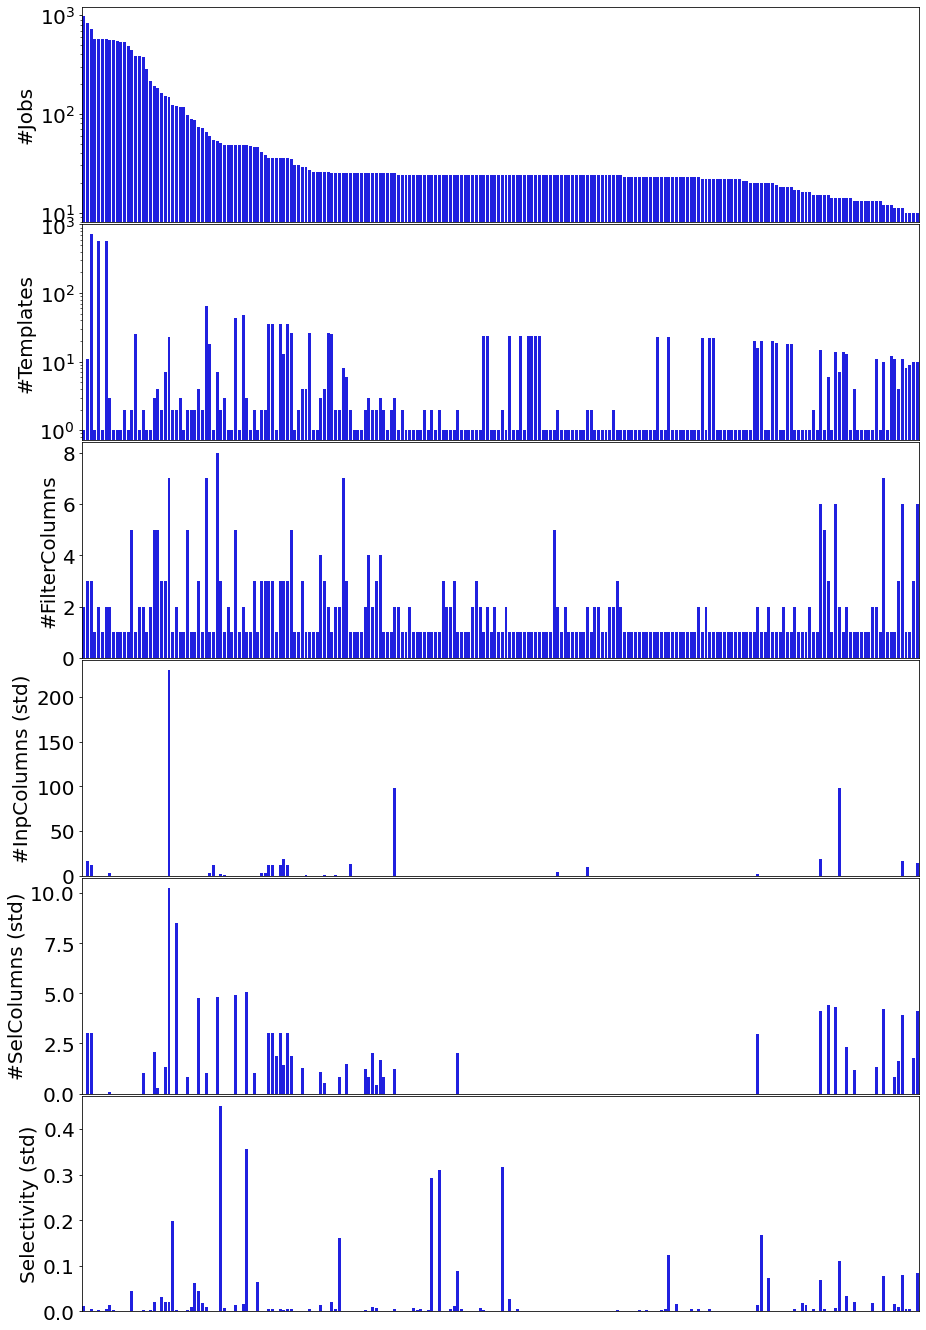

In [681]:
plot_input_stats(inp_stats, FIELDS5, "/Users/pari/Desktop/InputStats-Columns.pdf")

226
16619


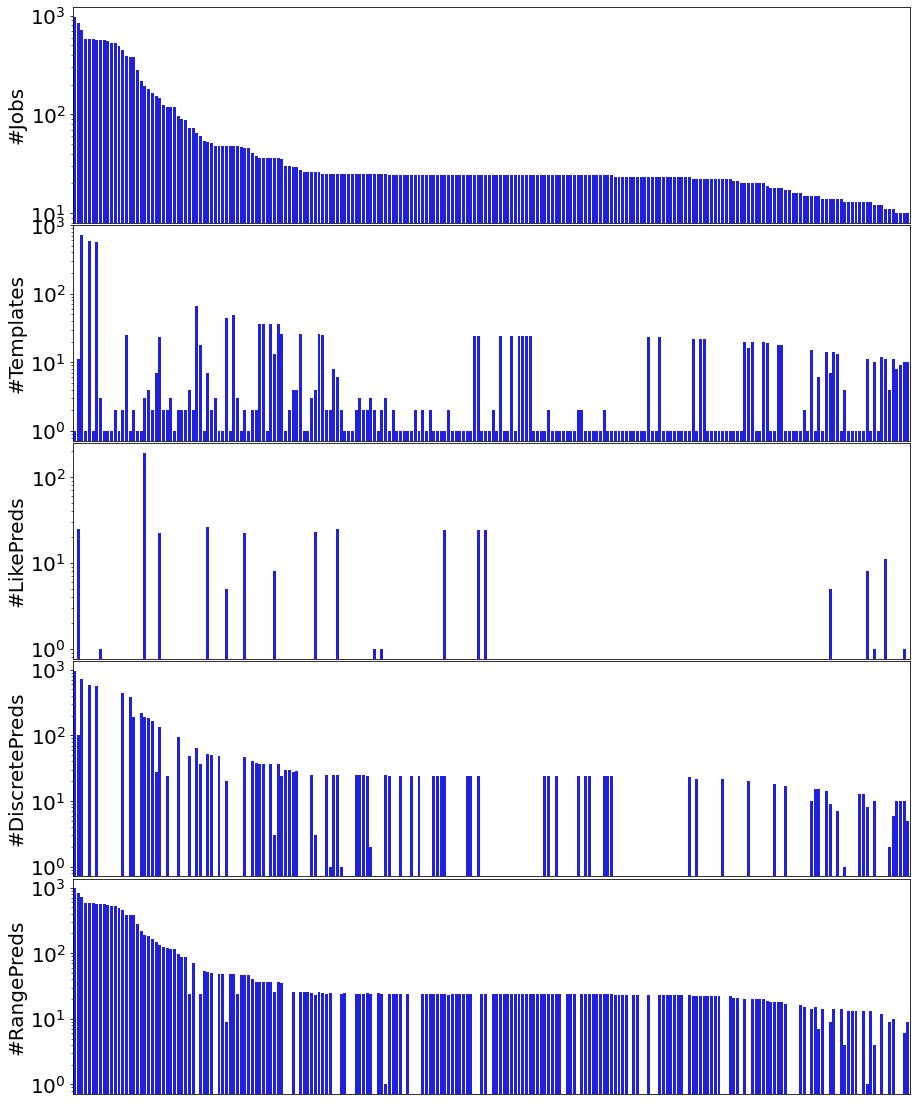

In [683]:
plot_input_stats(inp_stats, FIELDS, "/Users/pari/Desktop/InputStats-FilterKinds.pdf")

90
8108


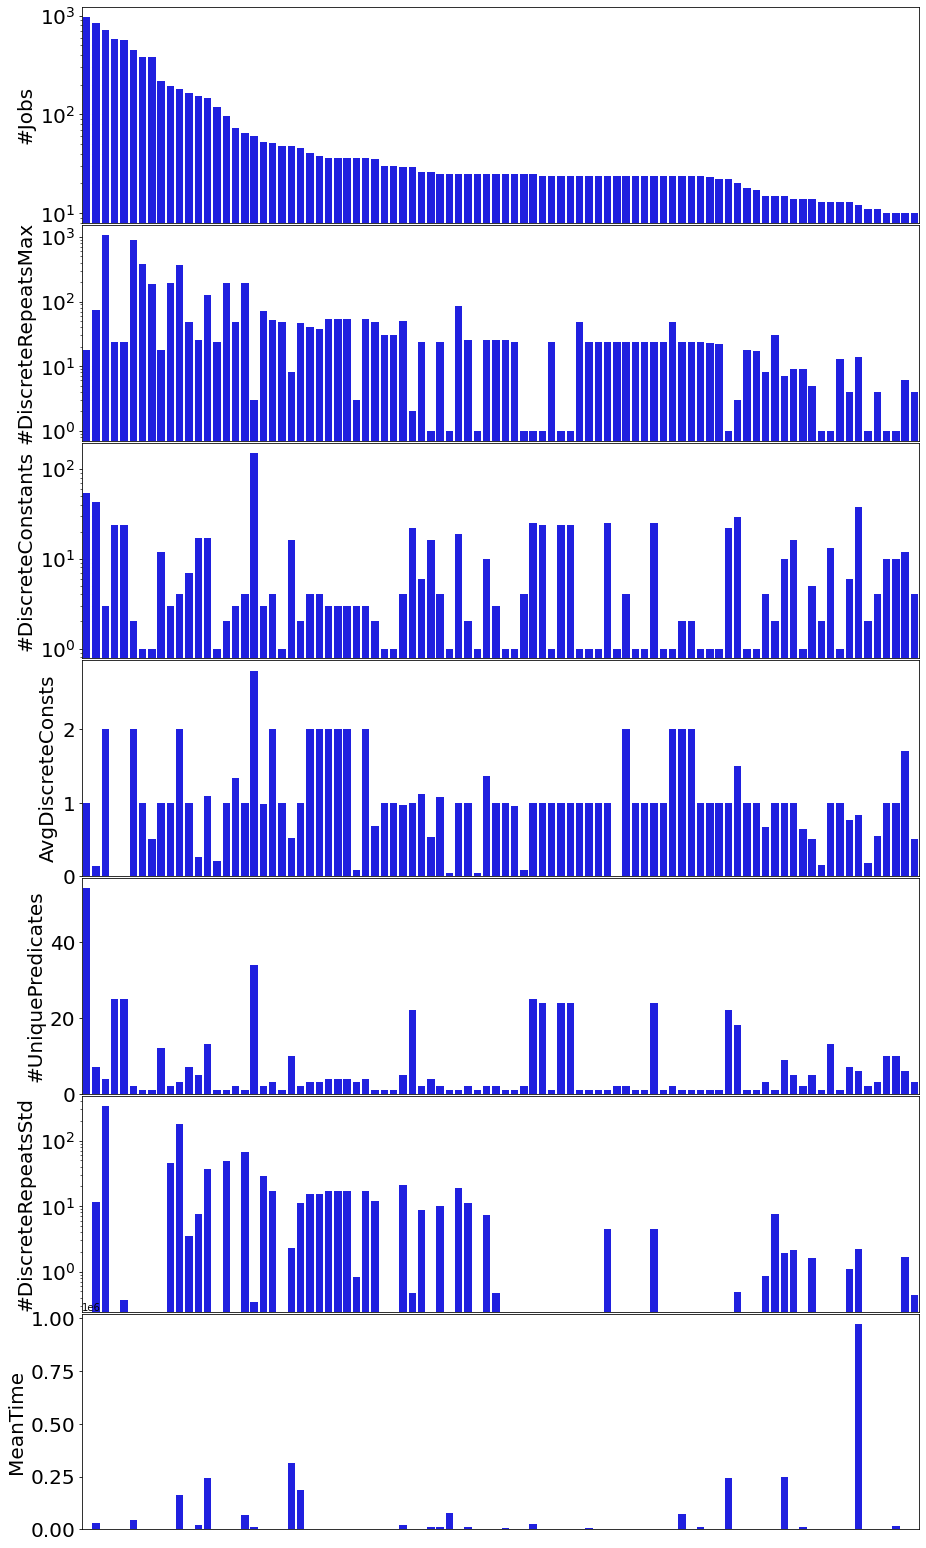

In [686]:
inp_stats2 = inp_stats[inp_stats["#DiscreteConstants"] != 0]
plot_input_stats(inp_stats2, FIELDS2, "/Users/pari/Desktop/InputStats-DiscreteConstants.pdf")

# Most of the repeated discrete values seem to be from shifting continuous values ---> sliding date windows

In [708]:
#inp_stats2.head(1)
for i in range(2):
    val = inp_stats2[INP_FIELD].values[i]
    #print(val)
    print(inp_to_discrete_consts[val])
    dfinp = df[df[INP_FIELD] == val]
    print(dfinp[FILTER_FIELD].values)

{'@"MSXLEADCOMPETITORS"': 18, '@"MSXLEAD"': 18, '@"MSXTERRITORY"': 18, '@"MSXCONSUMPTIONSERVICE"': 18, '@"MSXDYNAMICPROPERTY"': 18, '@"MSXPARTNERACCOUNT"': 18, '@"MSXBUSINESSUNIT"': 18, '@"MSXSALESORDER"': 18, '@"MSXPROCESSSTAGE"': 18, '@"MSXCONSENT"': 18, '@"MSXCAMPAIGN"': 18, '@"MSXLISTMEMBERBATCHES"': 18, '@"MSXLISTMEMBERS"': 18, '@"MSXPRODUCT"': 18, '@"MSXSELLERAPPCONSENT"': 18, '@"MSXTRANSACTIONCURRENCY"': 18, '@"MSXCOMPETITOR"': 18, '@"MSXEMAIL"': 18, '@"MSXSTRINGMAP"': 18, '@"MSXPRICELEVEL"': 18, '@"MSXLICENSINGPROGRAM"': 18, '@"MSXPRODUCTASSOCIATION"': 18, '@"MSXCAMPAIGNACTIVITY"': 18, '@"MSXAPP"': 18, '@"MSXSALESORDERDETAIL"': 18, '@"MSXCONTACT"': 18, '@"MSXACTIVITYPARTY"': 18, '@"MSXFAX"': 18, '@"MSXPHONECALL"': 18, '@"MSXOPPORTUNITYPRODUCT"': 18, '@"MSXTAXONOMYTYPE"': 18, '@"MSXCAMPAIGNRESPONSE"': 18, '@"MSXORDERCLOSE"': 18, '@"MSXAPPOINTMENT"': 18, '@"MSXACCOUNTDEVICEPROFILE"': 18, '@"MSXTAXONOMYTYPEDEPTH"': 18, '@"MSXOPPORTUNITYTEAM"': 18, '@"MSXCONSUMPTIONESTIMATE"': 18, 

In [ ]:
#INPNAME = "adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss"


20
2159


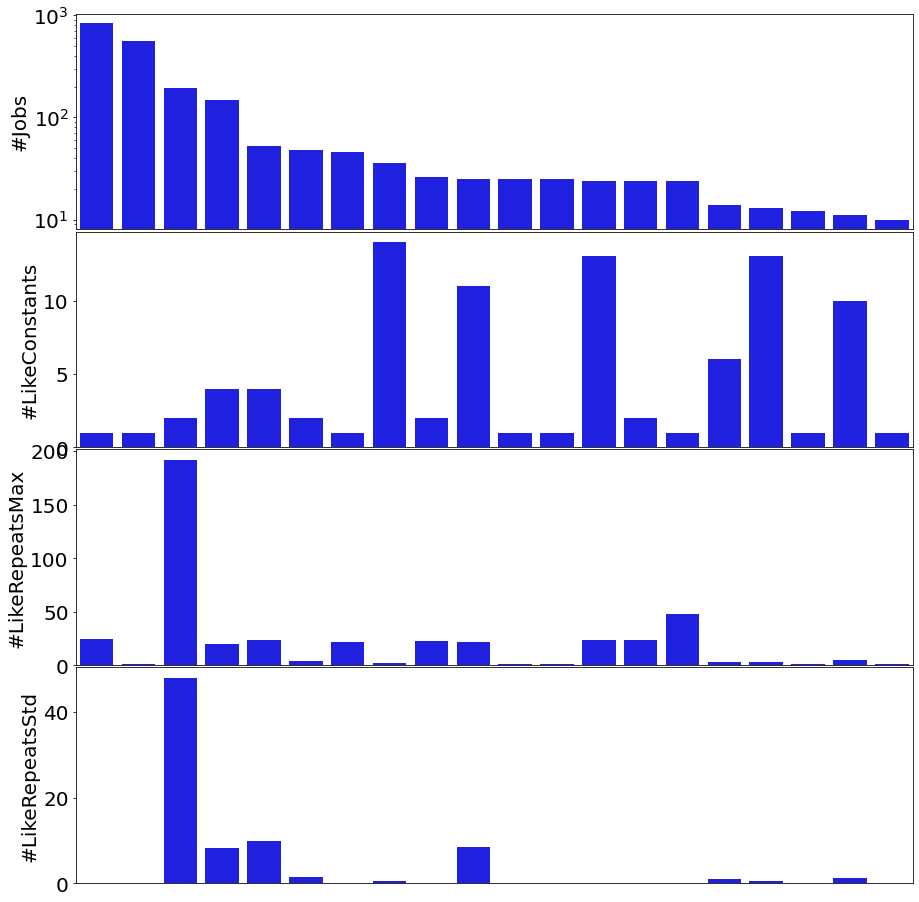

In [687]:
inp_stats3 = inp_stats[inp_stats["#LikeConstants"] != 0]
plot_input_stats(inp_stats3, FIELDS3, "/Users/pari/Desktop/InputStats-LikeConstants.pdf")

NameError: name 'inp_to_discdata' is not defined

226
16619


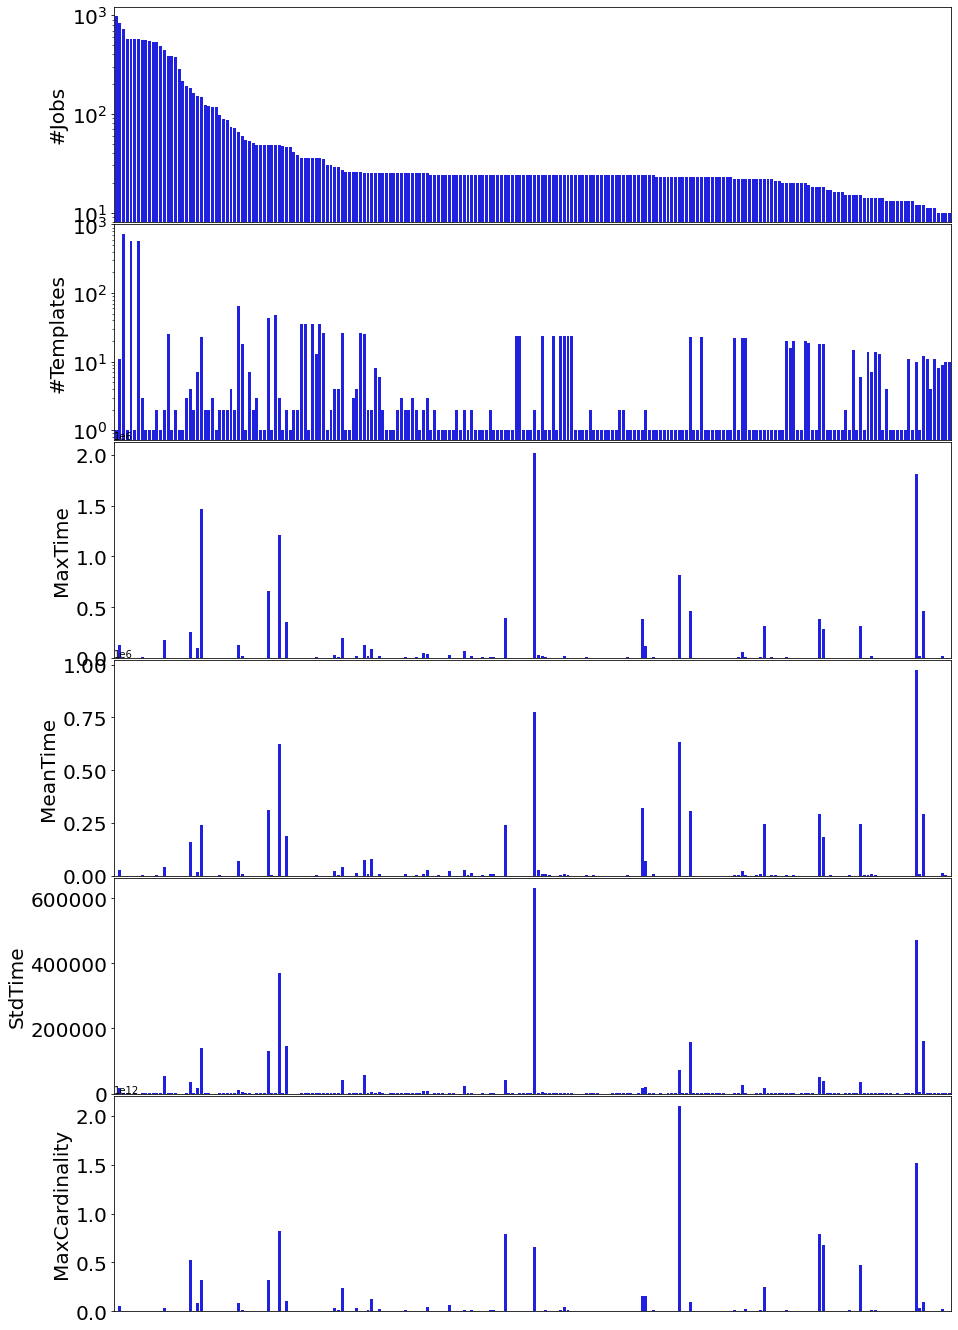

In [690]:
plot_input_stats(inp_stats, FIELDS4, "/Users/pari/Desktop/InputStats-Time.pdf")

# Exploring correlations

In [226]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AvgDiscreteConsts', 'MaxTime',
       'MeanTime', 'StdTime', 'MaxCardinality', '#LikePreds', '#RangePreds',
       '#DiscretePreds', '#UDFPreds', '#InPreds', '#EqualtoDate',
       'AllFilterColumns', 'FilterInPartition', '#DiscreteRepeatsMax',
       '#DiscreteConstants', '#DiscreteRepeatsStd', '#UniquePredicates',
       '#LikeConstants', '#LikeRepeatsMax', '#LikeRepeatsStd'],
      dtype='object')

In [227]:
corr_matrix = inp_stats.corr().abs()
corr_matrix["MaxTime"].reset_index().sort_values(by="MaxTime", ascending=False)

,index,MaxTime
9,MaxTime,1.000000
11,StdTime,0.990607
10,MeanTime,0.946467
1,Selectivity (std),0.462000
12,MaxCardinality,0.263619
2,Cardinality (std),0.240504
6,#Templates,0.208141
19,AllFilterColumns,0.090456
17,#InPreds,0.051782
4,#SelColumns (std),0.050232


# Exploring discrete constants

In [561]:
inp2 = inp_stats.sort_values("#DiscreteConstants", ascending=False)
print(inp2["NormInput"].head(10).values)
inp2.head(100)

<StringArray>
[                                                    'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss',
                          'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss',
                                                      'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Common/Dimensions/DimApp/VX/DimApp.ss',
 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
            'adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/Processed/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss',
                                                                   'adl://iebks-proddata-cX.azuredatalakestore.net/local/xblpet/cooked/data/vulcandb/db

,NormInput,#Jobs,Selectivity (std),Cardinality (std),#InpColumns (std),#SelColumns (std),#FilterColumns,#Templates,#PartitionColumns,AvgDiscreteConsts,...,#EqualtoDate,AllFilterColumns,FilterInPartition,#DiscreteRepeatsMax,#DiscreteConstants,#DiscreteRepeatsStd,#UniquePredicates,#LikeConstants,#LikeRepeatsMax,#LikeRepeatsStd
206,adl://supportanalytics-cX.azuredatalakestore.n...,71,0.001113,16697762.262756,2.576789,0.0,1,18,0.0,2.521127,...,0,4,0,5,152,0.574708,34,0,0,0.0
24,adl://jarvis-prod-cX.azuredatalakestore.net/lo...,972,0.011565,295.506982,0.0,0.0,1,1,2.0,1.0,...,0,1,2,18,54,0.000000,54,0,0,0.0
791,adl://asimov-prod-data-cX.azuredatalakestore.n...,10,0.002359,176155032.70555,0.0,2.898275,2,7,1.0,6.0,...,0,3,0,3,47,0.492589,9,0,0,0.0
144,adl://asimov-prod-data-cX.azuredatalakestore.n...,120,0.000268,72927.008781,0.0,11.544288,1,3,3.0,46.0,...,0,1,2,120,46,0.000000,1,0,0,0.0
28,adl://asimov-prod-data-cX.azuredatalakestore.n...,882,0.004416,181374747.589422,15.775453,3.027561,2,19,2.938776,0.401361,...,0,6,1,84,43,13.273183,7,1,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,adl://protection-adhoc-cX.azuredatalakestore.n...,19,0.083748,34218.187507,12.296531,4.287886,6,18,2.0,0.842105,...,0,10,0,12,4,0.000000,3,0,0,0.0
695,adl://protection-adhoc-cX.azuredatalakestore.n...,20,0.081991,34950.804865,13.164546,4.536402,6,20,2.0,0.7,...,0,8,0,12,4,1.732051,3,0,0,0.0
317,adl://asimov-prod-data-cX.azuredatalakestore.n...,48,0.028858,6962020.947762,0.0,1.010582,3,2,1.0,1.5,...,0,3,0,48,4,10.392305,3,0,0,0.0
555,adl://asimov-prod-data-cX.azuredatalakestore.n...,24,0.0,682.532879,0.0,0.0,4,1,1.0,2.0,...,0,4,0,24,4,0.000000,2,0,0,0.0


In [566]:
inptmp = inp_stats[inp_stats["#Jobs"] == 4564]
#inptmp = inp_stats[inp_stats["#Jobs"] == 71]
#inptmp = inp_stats[inp_stats["Selectivity (std)"] == 0.001113]

#INPNAME = 'adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Ingestion/MSaaSCase/Staging/Case.ss'
#INPNAME = 'adl://jarvis-prod-cX.azuredatalakestore.net/local/Integration/EnterpriseCommerceData/PartnerData/SalesDataHub/SalesDataHub_MSXRowCount.ss'
#INPNAME = 'adl://asimov-prod-data-cX.azuredatalakestore.net/local/PublicPartner/Processed/MDG/Watson/Snapshot/Instance/Hits/X/X/X/X/SnapshotResultThreshold_X_X_X_X__X_X_X.ss'
#inptmp = inp_stats[inp_stats["NormInput"] == INPNAME]

inpid = inptmp["NormInput"].values[0]
print(inpid)
df2 = df[df["NormInput"] == inpid]
print("Num unique jobs: ", len(set(df2["jobid"])))
print("Cols used: ", len(set(df2["unique_filter_cols"])))
print("Cont Ops used: ", set(df2["cont_ops"]))
print("Discrete ops used: ", set(df2["discrete_ops"]))
print("Like ops used: ", set(df2["like_ops"]))
print(df2.keys())
#df2
discdata = inp_to_discrete_consts[inpid]
print(discdata)
print(len(set(df2[FILTER_FIELD])))
print(df2[FILTER_FIELD].values[30])
print(len(set(df2["HashTagNonStrict"])))

adl://supportanalytics-cX.azuredatalakestore.net/local/Prod/SupportBI/Prod/Processed/BaseModel/Incident/Incident.Unified/Incident.Unified.ss
Num unique jobs:  621
Cols used:  4
Cont Ops used:  {0, 1}
Discrete ops used:  {0, 1}
Like ops used:  {0, 1}
Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount',
       'Selectivity', 'num_ops', 'num_unique_ops', 'unique_filter_cols',
       'num_cols_all', 'num_cols_sel', 'num_pcols', 'like_ops', 'discrete_ops',
       'cont_ops', 'udf_ops', 'in_ops', 'equal_dates', 'num_discrete_consts'],
      dtype='object')
{'"MSSolveODS"': 4530, 'null': 3, '"Closed"': 1}
36
{"isComparison":true,"expOperator":"!=","attribute":{"name":"DataSource:26","dataType":"String

# Exploring Like filters

In [ ]:
# for k,v in inp_to_discrete_consts.items():
#     print(k,v)
#     print("**********")

In [ ]:
#plot_input_stats(inp_stats, FIELDS3, "/Users/pari/Desktop/InputStats3-DiffTemplates.pdf")

# Most filters of the kind

In [ ]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df[FILTER_FIELD].values[0])

In [ ]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df[FILTER_FIELD].values[1])

In [ ]:
test_attr = tmp_df[FILTER_FIELD].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

In [ ]:
test_attr

In [ ]:
len(inp_to_cols[3929217785330710594])

In [ ]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

In [ ]:
inp_to_cols[test["HashTagInput"].values[0]]

In [ ]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

In [ ]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

# Exploring columns per input

In [ ]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

# How many sorted columns vs unsorted